In [3]:
from dipy.io.streamline import load_tck
from dipy.io.streamline import load_trk
import os,glob
from dipy.tracking.streamline import transform_streamlines
import nibabel as nib
import numpy as np
from dipy.viz import actor, window
from dipy.tracking.utils import length
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

import dipy as dp
#print(dp.__version__)
import shutil
import pandas as pd
#from numpy.polynomial import Polynomial
#from sklearn.metrics import r2_score
from scipy.stats import linregress
import time
#time.sleep(21600)

import statsmodels.api as sm
import statsmodels.formula.api as smf


ModuleNotFoundError: No module named 'dipy'

In [4]:
STUDY_PATH="/NAS/tupac/protocoles/Strokdem/"
TS_PATH=os.path.join(STUDY_PATH,"TractSeg")
OUT_PATH=os.path.join(TS_PATH,"data","disconn")
CODE_DIR=os.path.join(TS_PATH,"code")
LOG_DIR=os.path.join(CODE_DIR,"log")

NameError: name 'os' is not defined

In [5]:
%magic


IPython's 'magic' functions

The magic function system provides a series of functions which allow you to
control the behavior of IPython itself, plus a lot of system-type
features. There are two kinds of magics, line-oriented and cell-oriented.

Line magics are prefixed with the % character and work much like OS
command-line calls: they get as an argument the rest of the line, where
arguments are passed without parentheses or quotes.  For example, this will
time the given statement::

        %timeit range(1000)

Cell magics are prefixed with a double %%, and they are functions that get as
an argument not only the rest of the line, but also the lines below it in a
separate argument.  These magics are called with two arguments: the rest of the
call line and the body of the cell, consisting of the lines below the first.
For example::

        %%timeit x = numpy.random.randn((100, 100))
        numpy.linalg.svd(x)

will time the execution of the numpy svd routine, running the assignment 

In [10]:
#!pip3 install -U dipy
#!pip3 install -U fury
#!pip3 install Pandoc
#!pip3 install -U TractSeg

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 4.3 MB 2.4 MB/s eta 0:00:01
  Attempting uninstall: TractSeg
    Found existing installation: TractSeg 2.1.1
    Uninstalling TractSeg-2.1.1:
      Successfully uninstalled TractSeg-2.1.1


In [3]:
df_data = pd.read_excel(os.path.join(TS_PATH,'dti_database.xlsx'),engine='openpyxl',index_col=0,sheet_name="M6")
df_data.describe()

,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,...,Unnamed: 1014,Unnamed: 1015,Unnamed: 1016,Unnamed: 1017,Unnamed: 1018,Unnamed: 1019,Unnamed: 1020,Unnamed: 1021,Unnamed: 1022,Unnamed: 1023
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Procesing des DTI

In [173]:

listPat = [string for string in df_data.index if not "_ii" in string]
#listPat = ["540205BB"]
for TMP in ["72H","M6","M36","M60"] :
    print(TMP)
    OUT_PATH_TMP=os.path.join(OUT_PATH,TMP)
    #if not os.path.isdir(OUT_PATH_TMP) :
    #    os.mkdir(OUT_PATH_TMP)
    listeFile=glob.glob('/NAS/tupac/protocoles/Strokdem/data/*/*'+TMP+'/*.bval')
    listeFileWox=[string for string in listeFile if not "x201" in string]
    listeFileWox=[file for file in listeFileWox if os.path.isfile(file) and os.path.isfile(file.replace('bval','nii.gz')) and os.path.isfile(file.replace('bval','bvec')) ]    
    listeFileWox=[ string.replace('bval','nii.gz') for string in listeFileWox ]    
    
    listeFileCorr=glob.glob('/NAS/tupac/protocoles/Strokdem/data/*/*'+TMP+'/*corrections*.nii.gz')+glob.glob('/NAS/tupac/protocoles/Strokdem/data/*/*'+TMP+'/DTI_corrections_GOOD/*corrections*.nii.gz')+glob.glob('/NAS/tupac/protocoles/Strokdem/data/*/*'+TMP+'/*CORRECTIONS*.nii.gz')+glob.glob('/NAS/tupac/protocoles/Strokdem/data/*/*'+TMP+'/*/*DTICORRECTIONS*.nii.gz')
    listeFileCorrWoASL=[string for string in listeFileCorr if not "ASL" in string]
    listeFileCorrWoASL=[file for file in listeFileCorrWoASL if os.path.isfile(file)]    
        
    print(len(listeFileWox),len(listeFileCorrWoASL))
    for SUBJ in listPat :
        SUBJ=SUBJ.split('_')[0] #enleve les "_i" automatiquement cf. [string for string in df_data.index if "_i" in string]
        DTIFiles = [string for string in listeFileWox if SUBJ in string]
        CORRFiles = [string for string in listeFileCorrWoASL if SUBJ in string]
        #print(DTIFiles,CORRFiles)    
        if len(DTIFiles)>0 :
            CMD="qbatch -q two_job_q -oe "+LOG_DIR+" -N d_"+SUBJ+" bash "+os.path.join(CODE_DIR,"dti_process.sh ")+" "+SUBJ+" "+TMP
            os.system(CMD)
            #print(CMD)

72H
185 102
Your job 524464 ("d_571216AT") has been submitted
Your job 524465 ("d_431031JPC") has been submitted
Your job 524466 ("d_260410AV") has been submitted
Your job 524467 ("d_350605MM") has been submitted
Your job 524468 ("d_640425SV") has been submitted
Your job 524469 ("d_381020LF") has been submitted
Your job 524470 ("d_300403PP") has been submitted
Your job 524471 ("d_470323DV") has been submitted
Your job 524472 ("d_360826MB") has been submitted
Your job 524473 ("d_691229DB") has been submitted
Your job 524474 ("d_511202MS") has been submitted
Your job 524475 ("d_270525RL") has been submitted
Your job 524476 ("d_451229MTK") has been submitted
Your job 524477 ("d_231029JC") has been submitted
Your job 524478 ("d_561020LA") has been submitted
Your job 524479 ("d_440302HP") has been submitted
Your job 524480 ("d_660412LM") has been submitted
Your job 524481 ("d_311006LD") has been submitted
Your job 524482 ("d_560525GM") has been submitted
Your job 524483 ("d_560323CD") has b

In [163]:
listPat = [string for string in df_data.index if not "_ii" in string]
#listPat = ["540205BB"]
for TMP in ["72H","M6","M36","M60"] :
    print(TMP)
    OUT_PATH_TMP=os.path.join(OUT_PATH,TMP)
    if not os.path.isdir(OUT_PATH_TMP) :
        os.mkdir(OUT_PATH_TMP)
    listeFile=glob.glob('/NAS/tupac/protocoles/Strokdem/data/*/*'+TMP+'/*.bval')
    listeFileWox=[string for string in listeFile if not "x201" in string]
    listeFileWox=[file for file in listeFileWox if os.path.isfile(file) and os.path.isfile(file.replace('bval','nii.gz')) and os.path.isfile(file.replace('bval','bvec')) ]    
    listeFileWox=[ string.replace('bval','nii.gz') for string in listeFileWox ]    
    
    listeFileCorr=glob.glob('/NAS/tupac/protocoles/Strokdem/data/*/*'+TMP+'/*corrections*.nii.gz')+glob.glob('/NAS/tupac/protocoles/Strokdem/data/*/*'+TMP+'/DTI_corrections_GOOD/*corrections*.nii.gz')+glob.glob('/NAS/tupac/protocoles/Strokdem/data/*/*'+TMP+'/*CORRECTIONS*.nii.gz')+glob.glob('/NAS/tupac/protocoles/Strokdem/data/*/*'+TMP+'/*/*DTICORRECTIONS*.nii.gz')
    listeFileCorrWoASL=[string for string in listeFileCorr if not "ASL" in string]
    listeFileCorrWoASL=[file for file in listeFileCorrWoASL if os.path.isfile(file)]    
        
    print(len(listeFileWox),len(listeFileCorrWoASL))
    for SUBJ in listPat :
        SUBJ=SUBJ.split('_')[0] #enleve les "_i" automatiquement cf. [string for string in df_data.index if "_i" in string]
        DTIFiles = [string for string in listeFileWox if SUBJ in string]
        CORRFiles = [string for string in listeFileCorrWoASL if SUBJ in string]
        print(DTIFiles,CORRFiles)    
        if len(DTIFiles)==1 :
            IMA=DTIFiles[0]
            SUBJ_PATH=os.path.join(OUT_PATH_TMP,SUBJ)
            DTI_FILE=os.path.join(SUBJ_PATH,"dti_"+SUBJ+".nii.gz")

            if not os.path.isdir(SUBJ_PATH) :
                os.mkdir(SUBJ_PATH)
            if not os.path.isfile(DTI_FILE) :
                shutil.copy(IMA,DTI_FILE)

            if not os.path.isfile(DTI_FILE.split('.')[0]+".bval") :        
                shutil.copy(IMA.split('.')[0]+".bval",DTI_FILE.split('.')[0]+".bval")

            if not os.path.isfile(DTI_FILE.split('.')[0]+".bvec") :
                shutil.copy(IMA.split('.')[0]+".bvec",DTI_FILE.split('.')[0]+".bvec")

        if len(DTIFiles)==2 :
            IMA_1=DTIFiles[0]
            IMA_2=DTIFiles[1]
            SUBJ_PATH=os.path.join(OUT_PATH_TMP,SUBJ)
            DTI_FILE=os.path.join(SUBJ_PATH,"dti_"+SUBJ+".nii.gz")

            if not os.path.isdir(SUBJ_PATH) :
                os.mkdir(SUBJ_PATH)

            if not os.path.isfile(DTI_FILE) :
                !fslmerge -t $DTI_FILE $IMA_1 $IMA_2

            for VAL in [".bvec",".bval"] :
                tmp1=IMA_1.split('.')[0]+VAL
                tmp2=IMA_2.split('.')[0]+VAL
                tmp=os.path.join(SUBJ_PATH,'''dti_'''+SUBJ+VAL)
                if not os.path.isfile(tmp) :
                    !paste -d " " $tmp1 $tmp2 > $tmp

        if len(CORRFiles)>0 :
            SUBJ_PATH=os.path.join(OUT_PATH_TMP,SUBJ)
            DTI_CORR_FILE=os.path.join(SUBJ_PATH,"b0_PA_"+SUBJ+".nii.gz")
            DTI_PAIR=os.path.join(SUBJ_PATH,"b0_pair_"+SUBJ+".nii.gz")
            IMA=CORRFiles[0]

            if not os.path.isdir(SUBJ_PATH) :
                os.mkdir(SUBJ_PATH)

            if not os.path.isfile(DTI_CORR_FILE):
                ! mri_convert $IMA  $DTI_CORR_FILE --like $DTI_FILE
                #shutil.copy(IMA,DTI_CORR_FILE)

            DTI_FILE=os.path.join(SUBJ_PATH,"dti_"+SUBJ+".nii.gz")
            BVAL_FILE=os.path.join(SUBJ_PATH,"dti_"+SUBJ+".bval")
            BVEC_FILE=os.path.join(SUBJ_PATH,"dti_"+SUBJ+".bvec")

            if not os.path.isfile(DTI_PAIR):
                CMD="dwiextract -force -bzero "+DTI_FILE+" -fslgrad "+BVEC_FILE+" "+BVAL_FILE+" - | mrmath - mean - -axis 3 |mrcat - "+DTI_CORR_FILE+" -axis 3 "+DTI_PAIR
                os.system(CMD)
                #! dwiextract -force -bzero $DTI_FILE -fslgrad $BVEC_FILE $BVAL_FILE - | mrmath - mean - -axis 3 |mrcat - $DTI_CORR_FILE -axis 3 $DTI_PAIR

            f len(DTIFiles)>0 :
                CMD="qbatch -q two_job_q -oe "+LOG_DIR+" -N d_"+SUBJ+" bash "+os.path.join(CODE_DIR,"dti_process.sh ")+" "+SUBJ+" "+TMP
        

72H
185 102
['/NAS/tupac/protocoles/Strokdem/data/540205BB/540205BB_72H/WIP_DTI_15dir_serie_WIPDTI_15dirserie_20120120135819_9.nii.gz'] ['/NAS/tupac/protocoles/Strokdem/data/540205BB/540205BB_72H/DTI_corrections_GOOD/20120120_140329DTIcorrectionsGOODs010a001.nii.gz']
mri_convert.bin /NAS/tupac/protocoles/Strokdem/data/540205BB/540205BB_72H/DTI_corrections_GOOD/20120120_140329DTIcorrectionsGOODs010a001.nii.gz /NAS/tupac/protocoles/Strokdem/TractSeg/data/disconn/72H/540205BB/b0_PA_540205BB.nii.gz --like /NAS/tupac/protocoles/Strokdem/TractSeg/data/disconn/72H/540205BB/dti_540205BB.nii.gz 
$Id: mri_convert.c,v 1.226 2016/02/26 16:15:24 mreuter Exp $
reading from /NAS/tupac/protocoles/Strokdem/data/540205BB/540205BB_72H/DTI_corrections_GOOD/20120120_140329DTIcorrectionsGOODs010a001.nii.gz...
TR=12000.00, TE=0.00, TI=0.00, flip angle=0.00
i_ras = (-1, 0, 0)
j_ras = (0, 1, 0)
k_ras = (0, 0, 1)
INFO: transform src into the like-volume: /NAS/tupac/protocoles/Strokdem/TractSeg/data/disconn/72H/

dwiextract: [WARNING] existing output files will be overwritten
dwiextract: [100%] uncompressing image "/NAS/tupac/protocoles/Strokdem/TractSeg/data/disconn/72H/540205BB/dti_540205BB.nii.gz"[0K
dwiextract: [100%] extracting volumes[0K
mrmath: [100%] computing mean along axis 3...[0K
mrcat: [100%] concatenating "/tmp/mrtrix-tmp-HJRiCa.mif"[0K
mrcat: [100%] uncompressing image "/NAS/tupac/protocoles/Strokdem/TractSeg/data/disconn/72H/540205BB/b0_PA_540205BB.nii.gz"[0K
mrcat: [100%] concatenating "/NAS/tupac/protocoles/Strokdem/TractSeg/data/disconn/72H/540205BB/b0_PA_540205BB.nii.gz"[0K
mrcat: [100%] compressing image "/NAS/tupac/protocoles/Strokdem/TractSeg/data/disconn/72H/540205BB/b0_pair_540205BB.nii.gz"[0K


In [183]:
listPat = [string for string in df_data.index if not "_ii" in string]
#listPat = [ "810305BB" ]
cpt=0
for TMP in ["72H","M6","M36","M60"] :
    for SUBJ in listPat:
        SUBJ_PATH=os.path.join(OUT_PATH,SUBJ)
        #print(os.path.join("/NAS","dumbo","protocoles","Strokdem_discon","data",TMP,SUBJ,"whole_brain.tck"))
        if (not os.path.isfile(os.path.join("/NAS","dumbo","protocoles","Strokdem_discon","data",TMP,SUBJ,"whole_brain.tck"))):
            CMD="qbatch -q two_job_q -oe "+LOG_DIR+" -N Z_"+SUBJ+" bash "+os.path.join(CODE_DIR,"dti_process.sh ")+" "+SUBJ+" "+TMP
            os.system(CMD)
        else :
            cpt=cpt+1
print(cpt,'/',len(listPat))

Your job 526658 ("Z_510702MFB") has been submitted
Your job 526659 ("Z_540724JLC") has been submitted
Your job 526660 ("Z_340321SG") has been submitted
Your job 526661 ("Z_320428IM") has been submitted
Your job 526662 ("Z_580620CG") has been submitted
Your job 526663 ("Z_260426RK") has been submitted
Your job 526664 ("Z_310501VH") has been submitted
Your job 526665 ("Z_340301LD") has been submitted
Your job 526666 ("Z_541027GL") has been submitted
Your job 526667 ("Z_470815CM_i") has been submitted
Your job 526668 ("Z_610415JD_i") has been submitted
Your job 526669 ("Z_371116SD") has been submitted
Your job 526670 ("Z_510807WC_i") has been submitted
Your job 526671 ("Z_331212GL") has been submitted
Your job 526672 ("Z_690408PM") has been submitted
Your job 526673 ("Z_630418CM_i") has been submitted
Your job 526674 ("Z_371011SG") has been submitted
Your job 526675 ("Z_470101MT") has been submitted
Your job 526676 ("Z_250611RH") has been submitted
Your job 526677 ("Z_500921XD") has been 

In [223]:
listPat = [string for string in df_data.index if not "_ii" in string]
#listPat = [ "230805JA" ]
cpt=0
print("SUBJ,72H,M6,M36,M60")
for SUBJ in listPat:
    for TMP in ["72H","M6","M36","M60"] :
        RES_STR=SUBJ+"_"+TMP    
        SUBJ_PATH=os.path.join(OUT_PATH,SUBJ)    
        for TRK in ["CC_1","CC_2","CC_3","CC_4","CC_5","CC_6","CC_7","AF_left","STR_left","FPT_left","AF_right","STR_right","FPT_right"] :
            fil=os.path.join("/NAS","dumbo","protocoles","Strokdem_discon","data",TMP,SUBJ,"FOD_iFOD2_trackings",TRK+".tck")
            filFilt=os.path.join("/NAS","dumbo","protocoles","Strokdem_discon","data",TMP,SUBJ,"FOD_iFOD2_trackings",TRK+"filtered.tck")
            #print(fil,filFilt)
            if (os.path.isfile(fil) and not os.path.isfile(filFilt)):
                bundle=load_tck(fil,os.path.join("/NAS","dumbo","protocoles","Strokdem_discon","data",TMP,SUBJ,"FA.nii.gz"))
              
                if len(bundle.streamlines)>0 :
                    RES_STR+=",0"   
                    CMD="qbatch -q M32_q -oe "+LOG_DIR+" -N D_"+SUBJ+"_"+TMP+"_"+STR+" /home/global/anaconda37/bin/python /home/romain/SVN/python/romain/PostProcessBundle.py "+" "+TMP+" "+SUBJ+" "+TRK
                    os.system(CMD)
                    #print(CMD)
                else :
                    RES_STR+=",1"                
            else :
                RES_STR+=",1"            
        print(RES_STR)

SUBJ,72H,M6,M36,M60
510702MFB_72H,1,1,1,1,1,1,1,1,1,1,1,1,1
510702MFB_M6,1,1,1,1,1,1,1,1,1,1,1,1,1
510702MFB_M36,1,1,1,1,1,1,1,1,1,1,1,1,1
510702MFB_M60,1,1,1,1,1,1,1,1,1,1,1,1,1
540724JLC_72H,1,1,1,1,1,1,1,1,1,1,1,1,1
540724JLC_M6,1,1,1,1,1,1,1,1,1,1,1,1,1
540724JLC_M36,1,1,1,1,1,1,1,1,1,1,1,1,1
540724JLC_M60,1,1,1,1,1,1,1,1,1,1,1,1,1
571216AT_72H,1,1,1,1,1,1,1,1,1,1,1,1,1
571216AT_M6,1,1,1,1,1,1,1,1,1,1,1,1,1
571216AT_M36,1,1,1,1,1,1,1,1,1,1,1,1,1
571216AT_M60,1,1,1,1,1,1,1,1,1,1,1,1,1
431031JPC_72H,1,1,1,1,1,1,1,1,1,1,1,1,1
431031JPC_M6,1,1,1,1,1,1,1,1,1,1,1,1,1
431031JPC_M36,1,1,1,1,1,1,1,1,1,1,1,1,1
431031JPC_M60,1,1,1,1,1,1,1,1,1,1,1,1,1
260410AV_72H,1,1,1,1,1,1,1,1,1,1,1,1,1
260410AV_M6,1,1,1,1,1,1,1,1,1,1,1,1,1
260410AV_M36,1,1,1,1,1,1,1,1,1,1,1,1,1
260410AV_M60,1,1,1,1,1,1,1,1,1,1,1,1,1
350605MM_72H,1,1,1,1,1,1,1,1,1,1,1,1,1
350605MM_M6,1,1,1,1,1,1,1,1,1,1,1,1,1
350605MM_M36,1,1,1,1,1,1,1,1,1,1,1,1,1
350605MM_M60,1,1,1,1,1,1,1,1,1,1,1,1,1
640425SV_72H,1,1,1,1,1,1,1,1,1,1,1,1,1

In [7]:
import os,sys
import argparse
import math
from decimal import Decimal
from os.path import join
import statsmodels.api as sm

import numpy as np
import matplotlib.pyplot as plt
import plotnine as p9

import seaborn as sns
import scipy.stats
import pandas as pd
from tqdm import tqdm

import glob as glob
import nibabel as nib
from scipy.stats import t as t_dist
#from tractseg.libs import plot_utils
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

from tractseg.libs import tractometry
from tractseg.libs import tracking

from tractseg.data import dataset_specific_utils
from tractseg.libs.AFQ_MultiCompCorrection import AFQ_MultiCompCorrection
from tractseg.libs.AFQ_MultiCompCorrection import get_significant_areas
from tractseg.libs import metric_utils
from dipy.tracking.utils import length

In [8]:
STUDY_PATH=os.path.join("/NAS","dumbo","protocoles","Strokdem_discon")
IMAGES_DIR=STUDY_PATH+'TractSeg_output/'
TRACTO_DIR=STUDY_PATH+'TractSeg/'
PARA="FA"
ALGORITHM="distance_map"

listPat = [string for string in df_data.index if not "_ii" in string]
#listPat = [ "230805JA" ]

#if not os.path.exists(Profiles_file+'.npy') :
for NR_PT in np.linspace(20,100,5) :
    NR_POINTS=int(NR_PT)
    if (ALGORITHM == '''afq''') :
        npvalues = np.zeros([len(listPat),98])
    else :
        npvalues = np.zeros([len(listPat),NR_POINTS])

    for TMP in ["72H","M6","M36","M60"] :
        for idx,SUBJ in enumerate(listPat):
            for TRK in ["CC_2","CC_3","CC_4","CC_5","CC_6","CC_7","AF_left","STR_left","FPT_left","AF_right","STR_right","FPT_right"] : #["CC_1"] : 
                TRACTO_TCK=os.path.join(STUDY_PATH,"data",TMP,SUBJ,"FOD_iFOD2_trackings",TRK+"filtered.tck")
                if os.path.isfile(TRACTO_TCK) :# and os.path.exists(TRACTO_TCK) :
                    SCALAR_IMG=os.path.join(STUDY_PATH,"data",TMP,SUBJ,PARA+'.nii.gz')
                    START_IMG=os.path.join(STUDY_PATH,"data",TMP,SUBJ,'endings_segmentations',TRK+"_b.nii.gz")
                    scalar_image = nib.load(SCALAR_IMG)
                    beginnings = nib.load(START_IMG)
                    sl_file = nib.streamlines.load(TRACTO_TCK)
                    streamlines = sl_file.streamlines
                    val=list(length(streamlines))
                    if len(streamlines) > 5 :
                        mean, std = tractometry.evaluate_along_streamlines(np.nan_to_num(scalar_image.get_fdata()), streamlines,beginnings.get_fdata(), NR_POINTS+2, dilate=2,predicted_peaks=None, affine=scalar_image.affine)
                        #evaluate_along_streamlines_withAlgo(np.nan_to_num(scalar_image.get_fdata()), streamlines,beginnings.get_fdata(), NR_POINTS+2, dilate=2,predicted_peaks=None, affine=scalar_image.affine,algorithm=ALGORITHM)
                        npvalues[idx, :] = mean[1:-1]
                    #npvalues
                    Profiles_file=os.path.join(STUDY_PATH,"data",PARA+"_"+TMP+"_"+TRK+"_"+ALGORITHM+"_"+str(NR_POINTS))
                    np.save(Profiles_file,npvalues)

(202, 80)


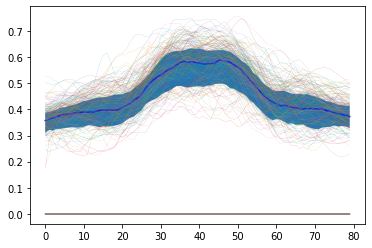

In [8]:
npvalues=np.load("/NAS/dumbo/protocoles/Strokdem_discon/data/FA_M60_CC_1_distance_map_80.npy")
print(npvalues.shape)
#%matplotlib inline
plt.plot(np.median(npvalues,axis=0),'b')
plt.fill_between(np.linspace(0,npvalues.shape[1]-1,npvalues.shape[1]),np.percentile(npvalues,25,axis=0),np.percentile(npvalues,75,axis=0))
plt.plot(np.transpose(npvalues),linewidth=0.1)

#plt.plot(numpy.percentile(data,75,axis=0))
#plt.plot(numpy.flipud(numpy.mean(CST_right_nd[numpy.mean(CST_right_nd,axis=1)>0.3],axis=0)))
plt.show()

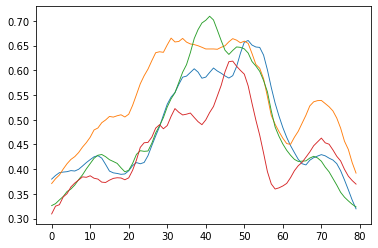

In [10]:
plt.plot(np.transpose(npvalues[1:5,:]),linewidth=0.9)

In [16]:
for col in df_RL.columns :
    print(col)

SEXE
AGE
NB_AN_SCOL
IQ_CODE
BMI
FRISQUVASC_DIAB
FRISQUVASC_HYPCHOL
FRISQUVASC_HYPTRI
FRISQUVASC_TABAC
FACTEUR_ALCOOL
NIHSS_SCORE_J7
NIHSS_SCORE_M6
NIHSS_SCORE_M12
NIHSS_SCORE_M36
SCORE_RANKIN_J7
SCORE_RANKIN_M6
SCORE_RANKIN_M12
SCORE_RANKIN_M36
mRS_OUTCOME_J7
mRS_OUTCOME_M6
mRS_OUTCOME_M12
mRS_OUTCOME_M36
MMSE_SCORE_J7
MMSE_SCORE_M6
MMSE_SCORE_M12
MMSE_SCORE_M36
MOCA_SCORE_J7
MOCA_SCORE_M6
MOCA_SCORE_M12
MOCA_SCORE_M36
SYND_TB_COG_M6_M6
SYND_TB_COG_M6_M12
SYND_TB_COG_M6_M36
DO_COG_M6
DO_COG_M36
DO_COG_M6_M36
CONVERTERS_M6_M36
SYND_TB_COG_M6_DOM36
SYND_TB_COG_M36_DOM6
INFARCT_VOL T1space GK cm3
INFARCT_VOL T1space GK %
WMH_VOL_T1space_M6 cm3
WMH_VOL_T1space_M6 %
SUPRA_OR_INFRA
INFARCT_SIDE
VASCULAR_TERRITORIES
STROKOMEMO_M6
STROKOMEMO_M36
STROKOEXE_M6
STROKOEXE_M36
STROKOATT_M6
STROKOATT_M36
STROKOPERCEPT_M6
STROKOPERCEPT_M36
STROKOLANG_M6
STROKOLANG_M36
Tissue IC cm3
Tissue Brain cm3
Tissue CSF cm3
Cerebrum T GM cm3
Cerebrum T WM cm3
Cerebrum Right cm3
Cerebrum R GM cm3
Cerebrum R WM c

In [76]:
myDict = {"CC_1":"CCAnterior",
          "CC_2":"CCMidAnterior",
          "CC_3":"CCMidAnterior",
          "CC_4":"CCCentral",
          "CC_5":"CCMidPosterior",
          "CC_6":"CCMidPosterior",
          "CC_7":"CCPosterior",
          "FPT_left":"FPT_L",
          "FPT_right":"FPT_R",
          "STR_left":"RST_L",
          "STR_right":"RST_R",          
          }

/home/romain/.local/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
/home/romain/.local/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
/home/romain/.local/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
/home/romain/.local/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
/home/romain/.local/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
/home/romain/.local/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
/home/romain/.local/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encount

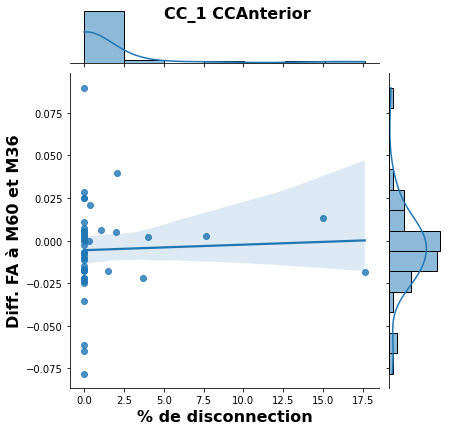

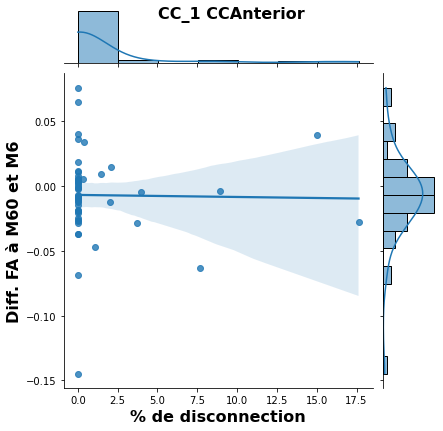

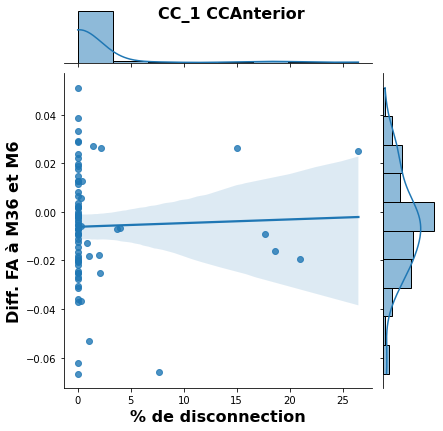

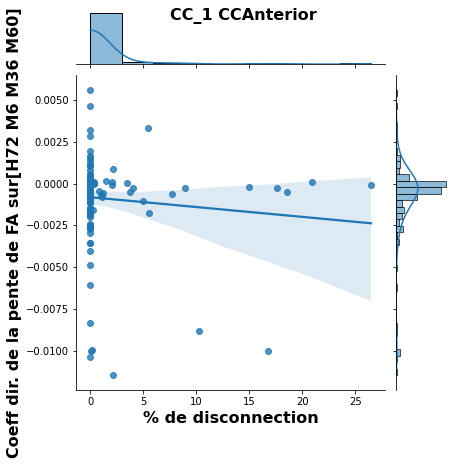

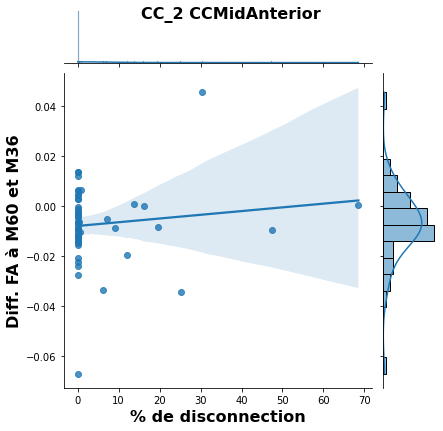

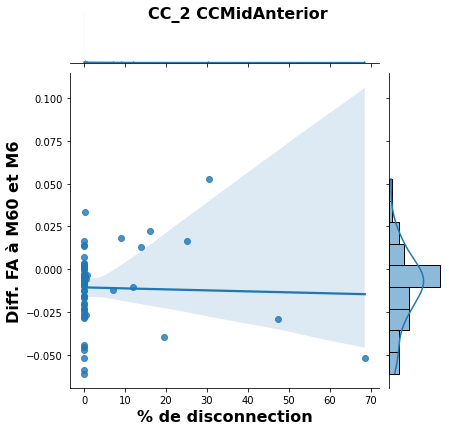

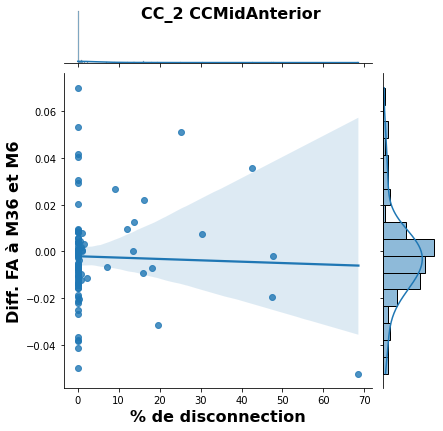

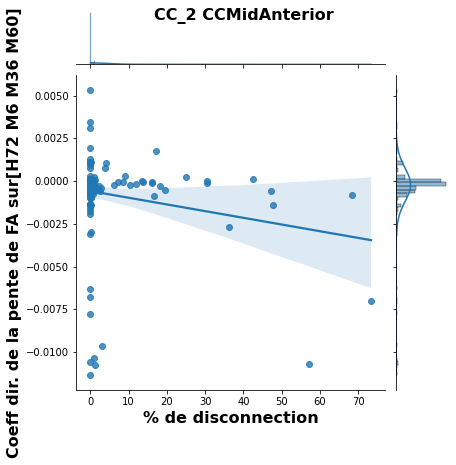

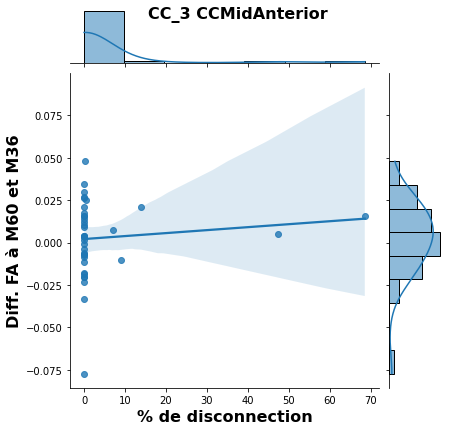

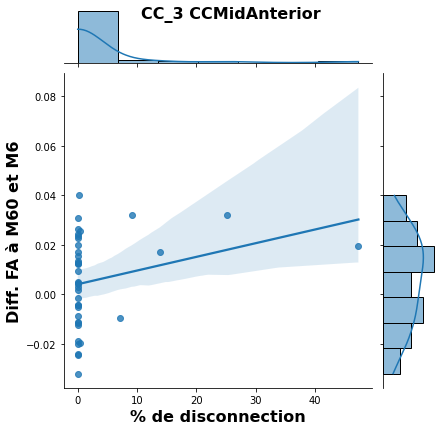

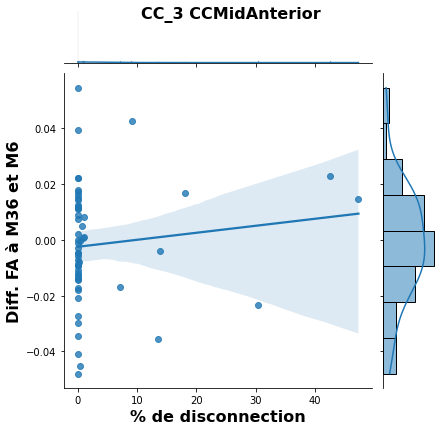

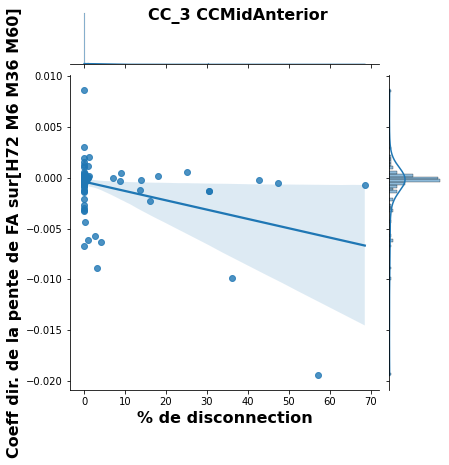

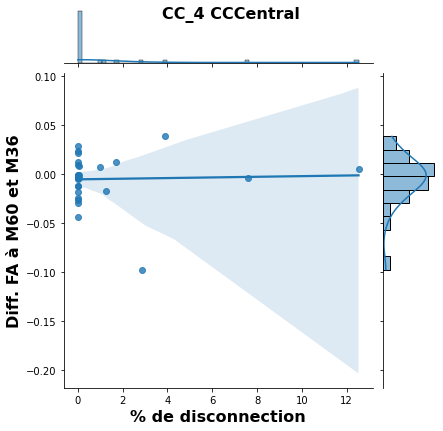

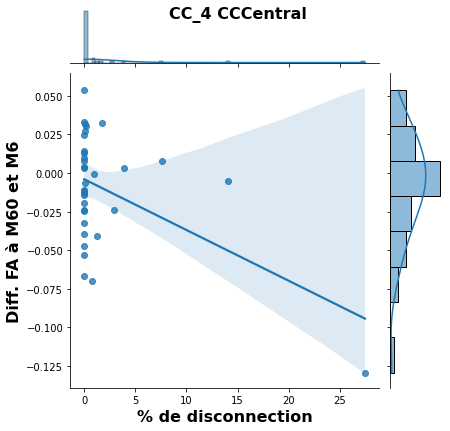

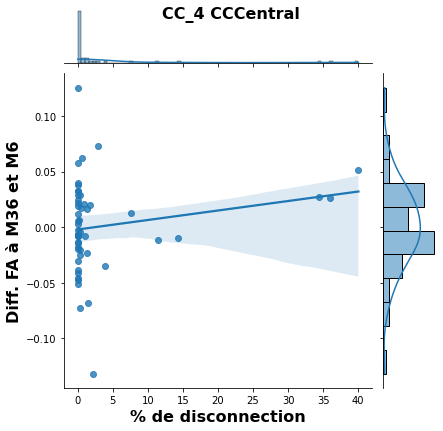

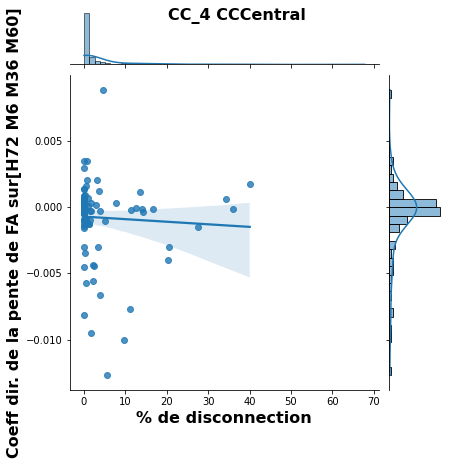

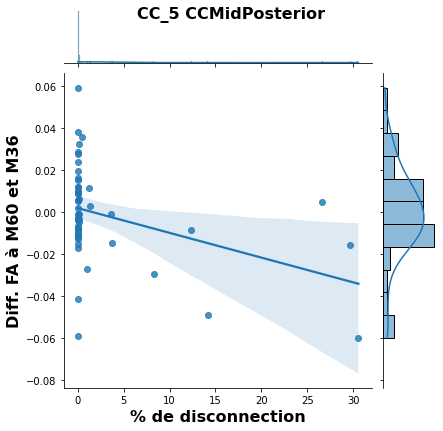

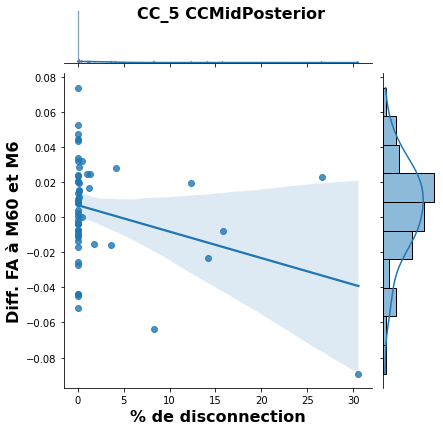

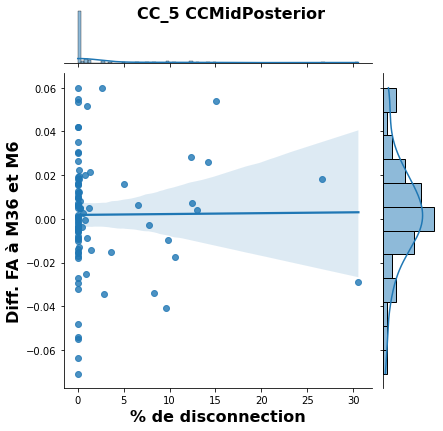

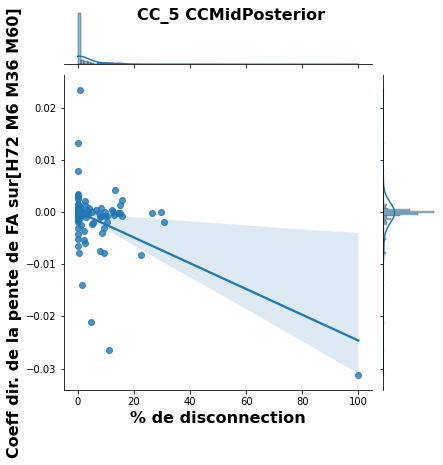

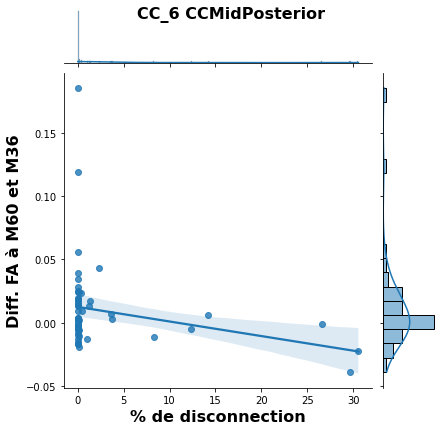

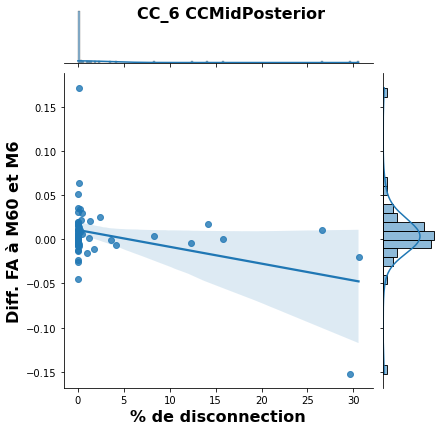

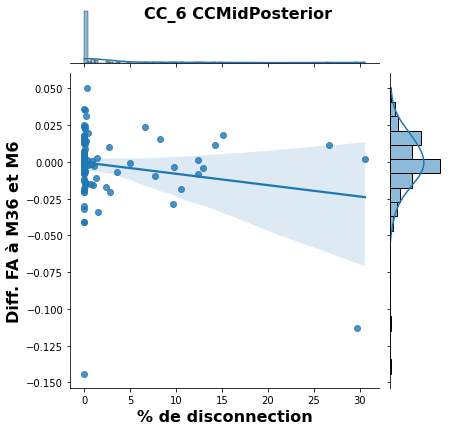

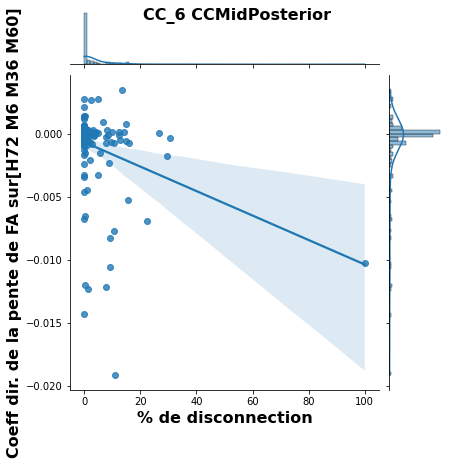

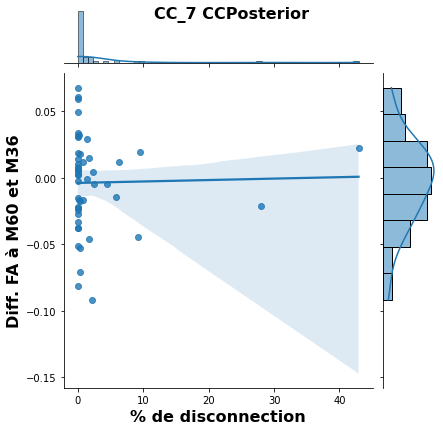

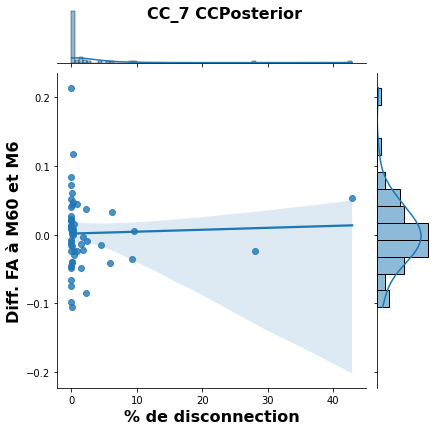

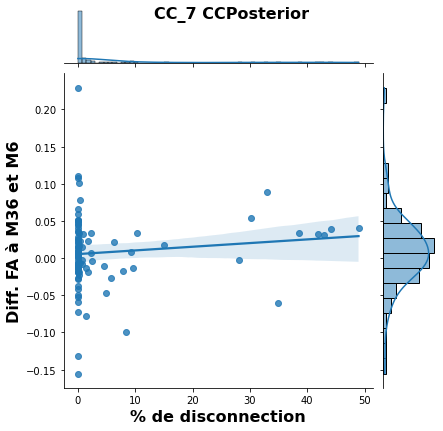

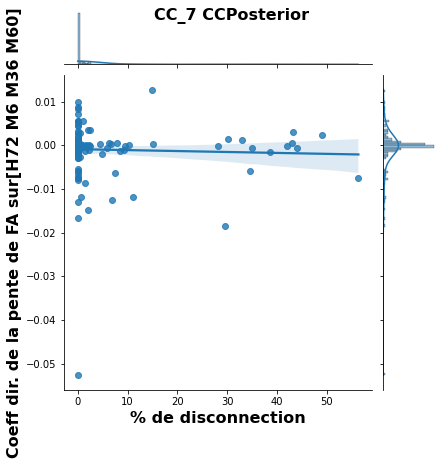

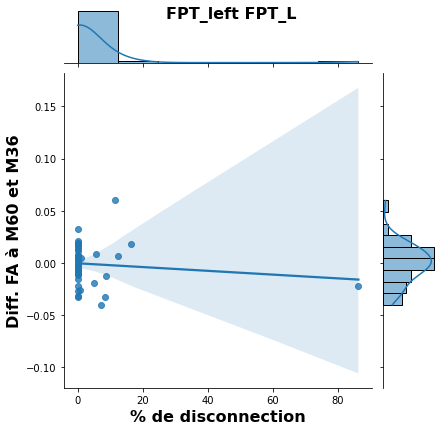

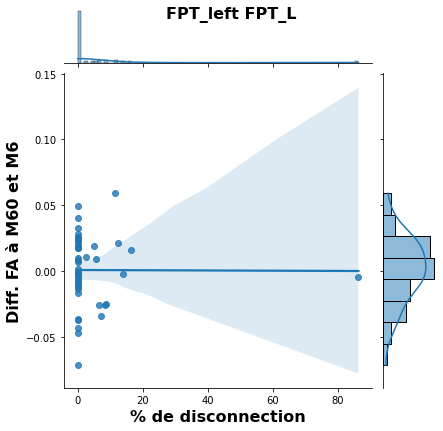

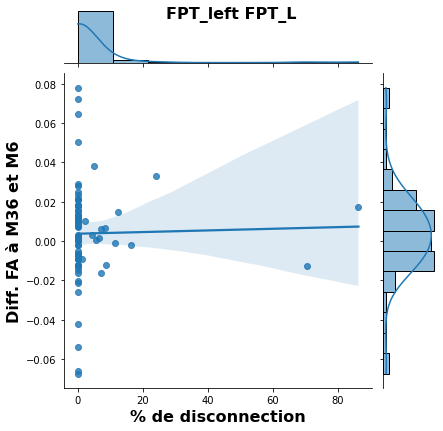

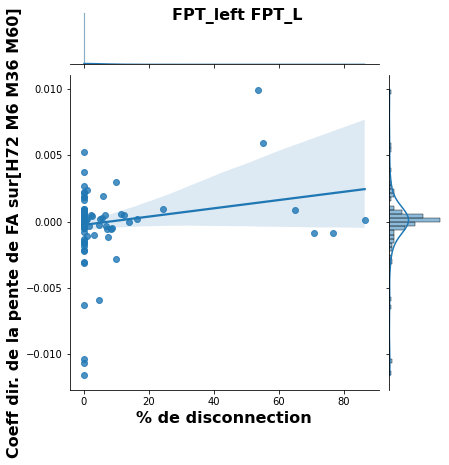

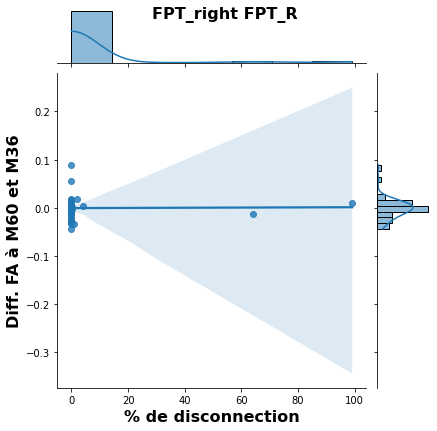

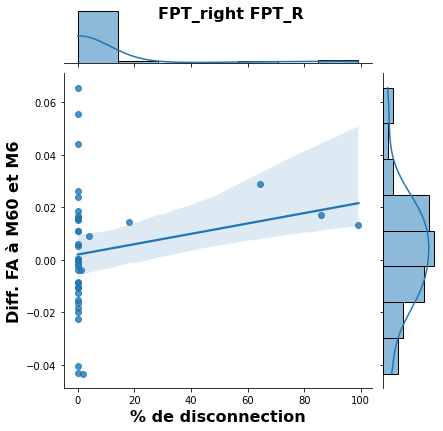

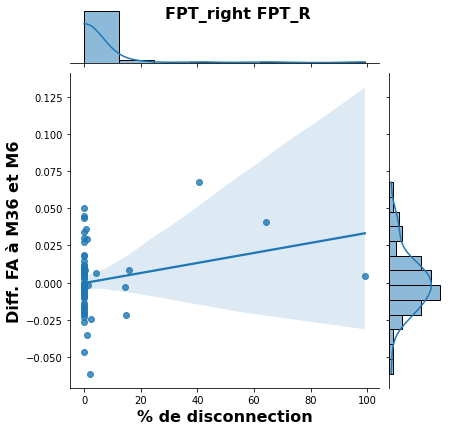

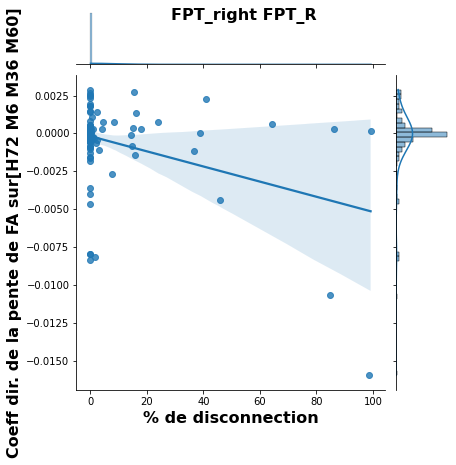

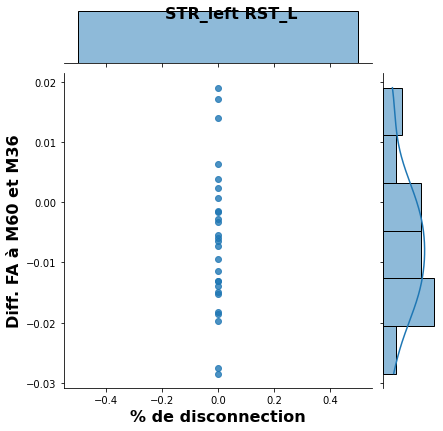

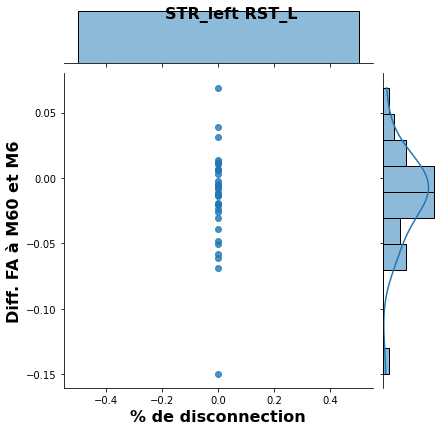

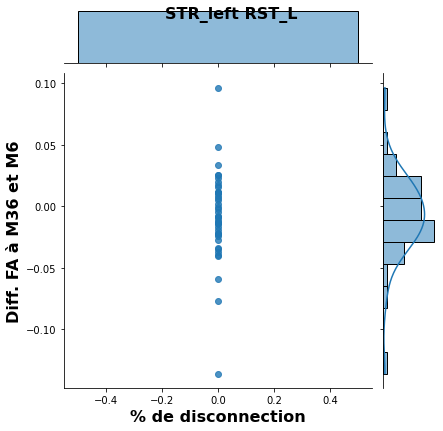

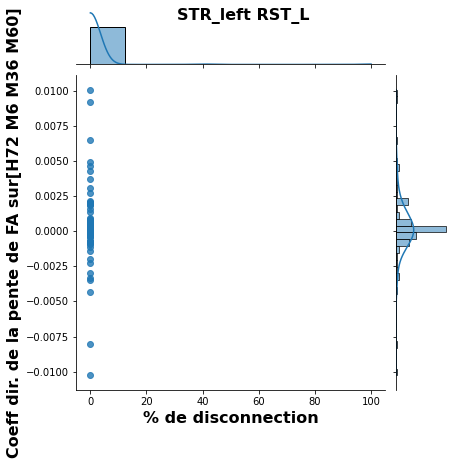

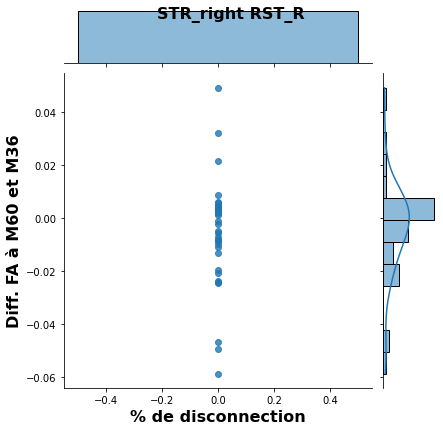

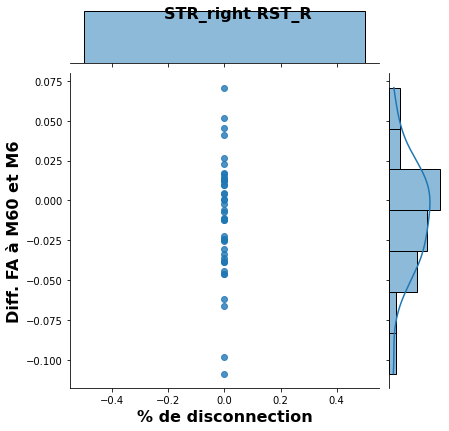

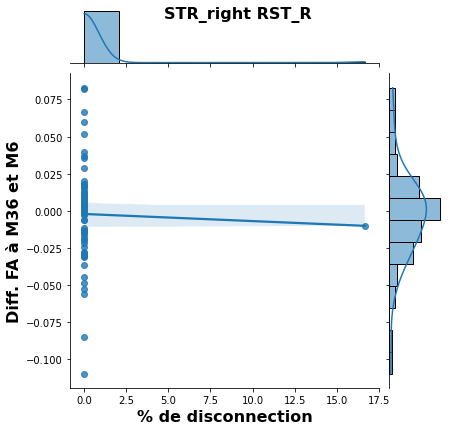

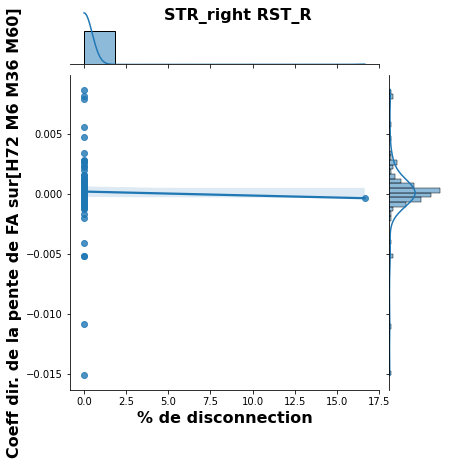

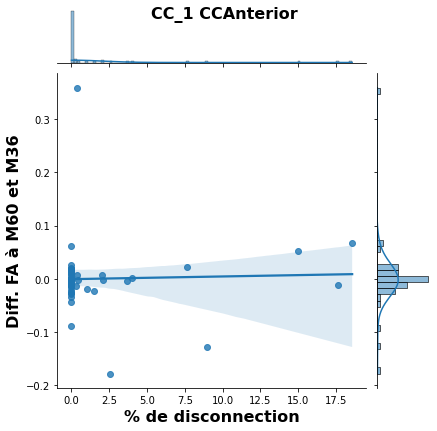

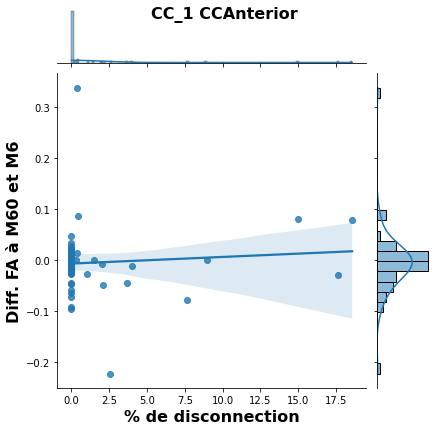

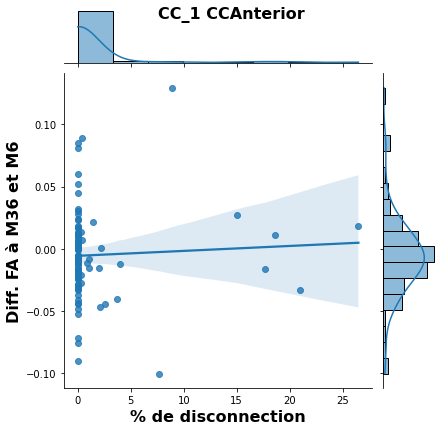

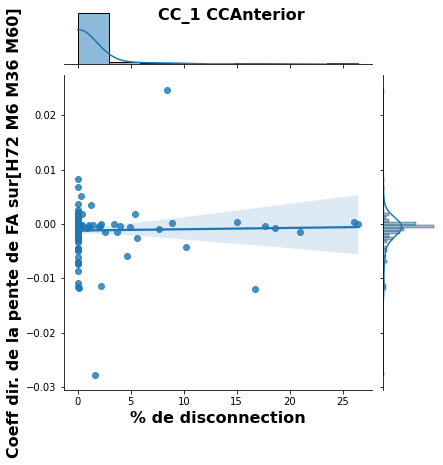

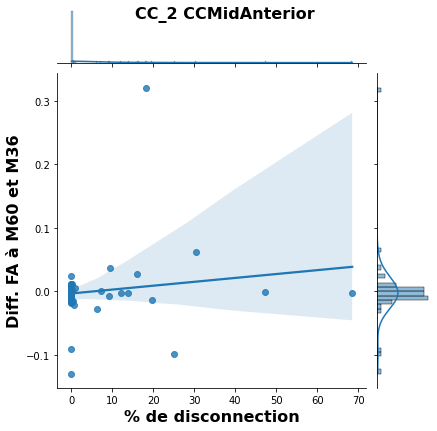

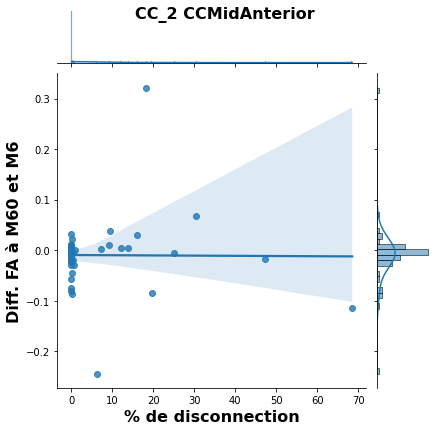

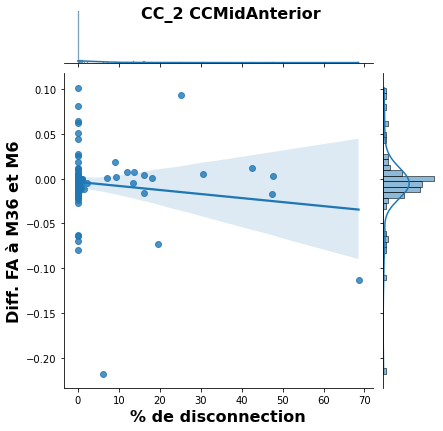

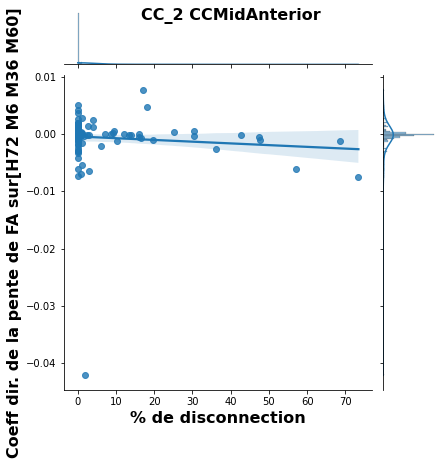

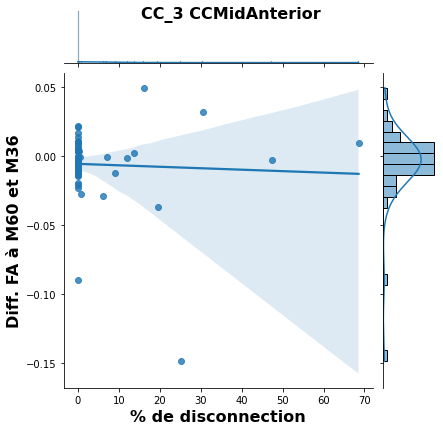

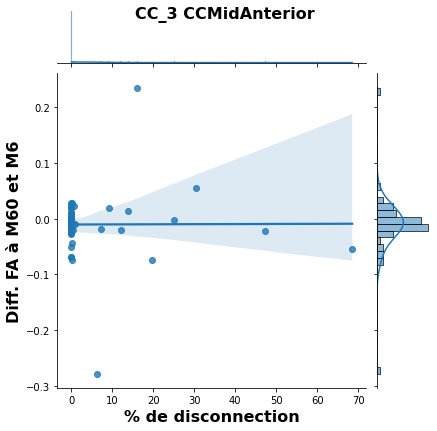

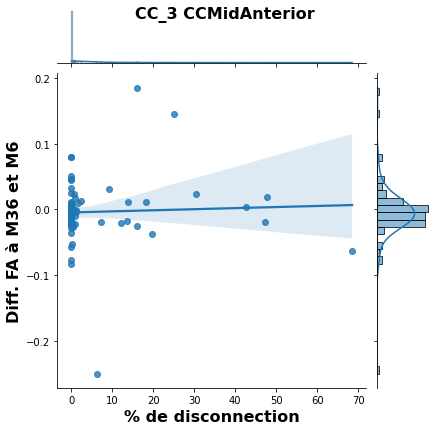

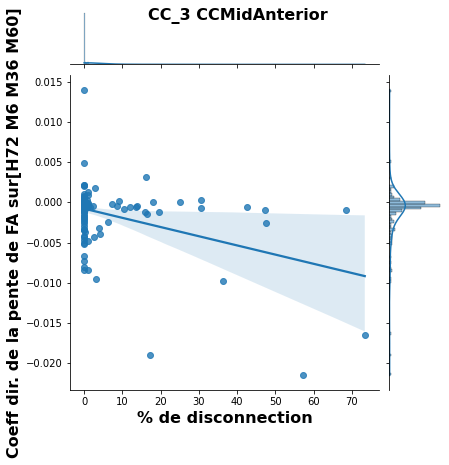

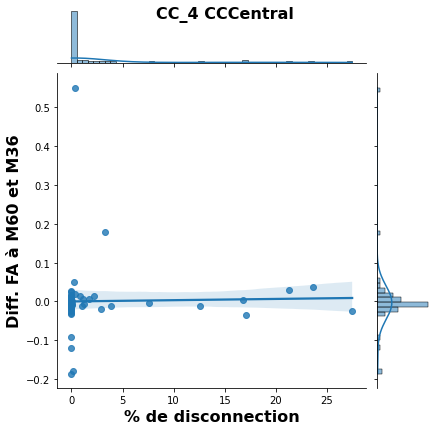

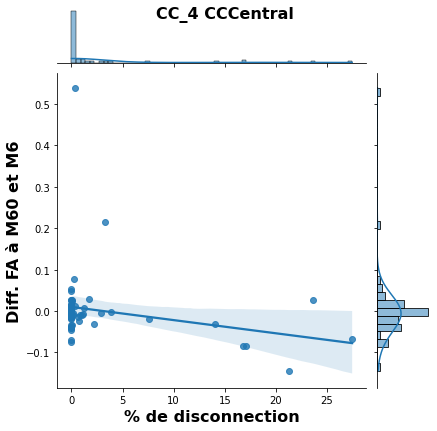

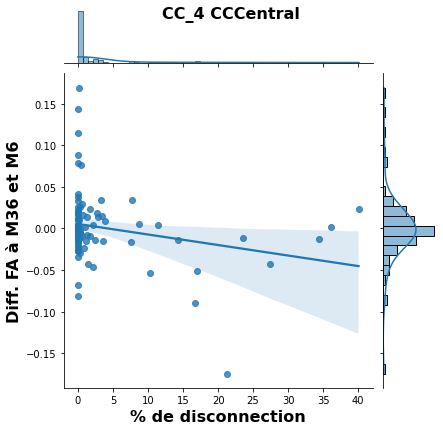

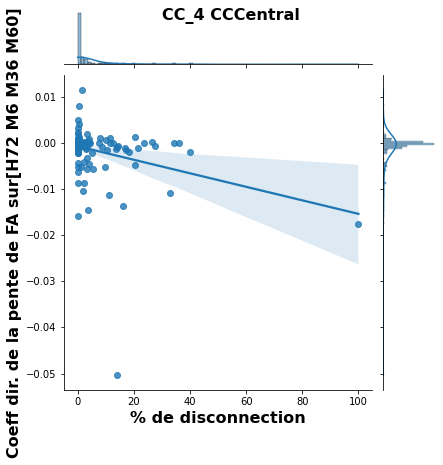

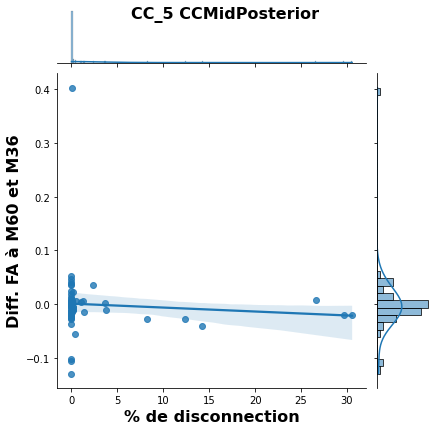

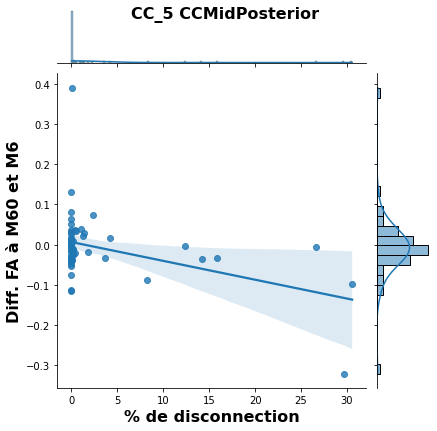

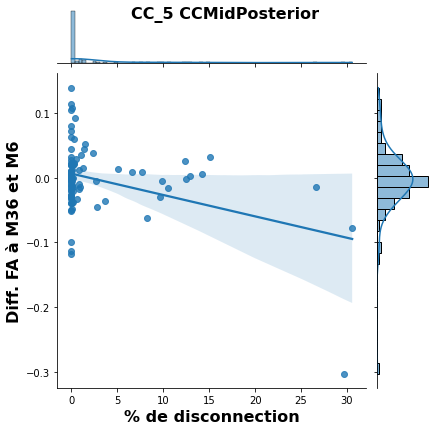

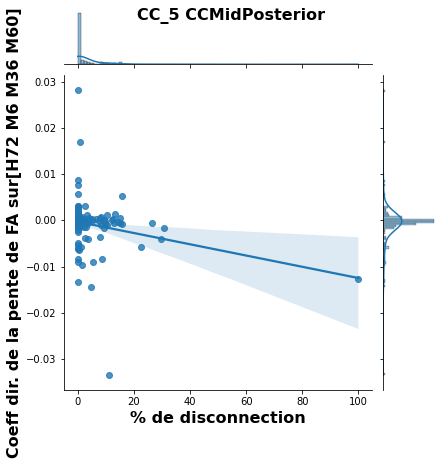

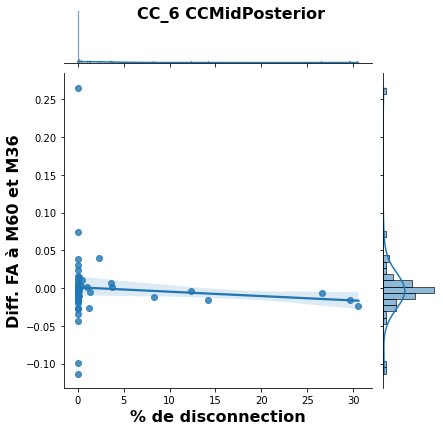

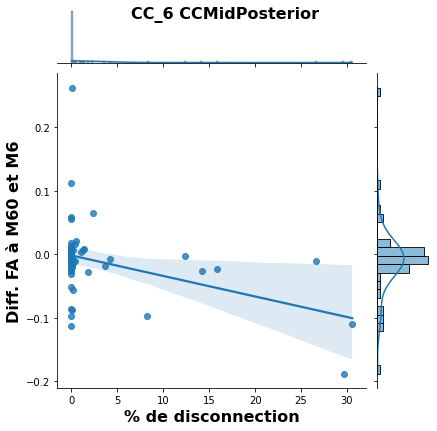

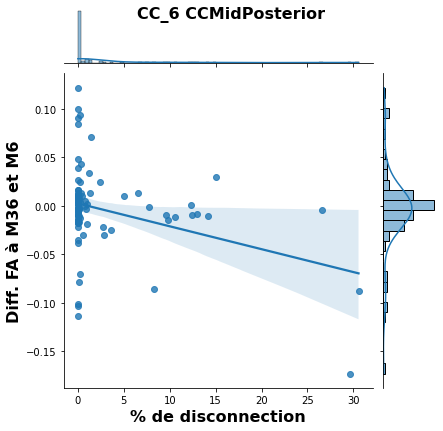

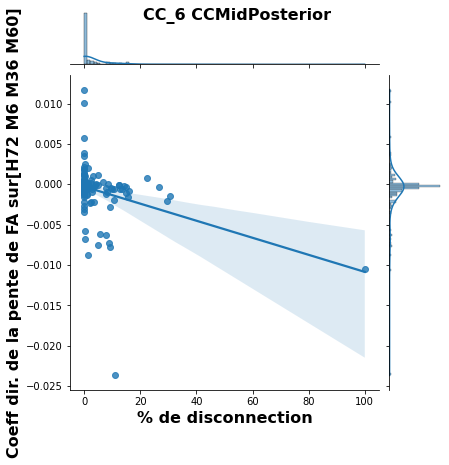

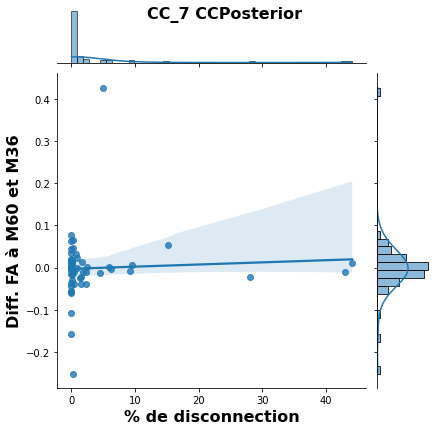

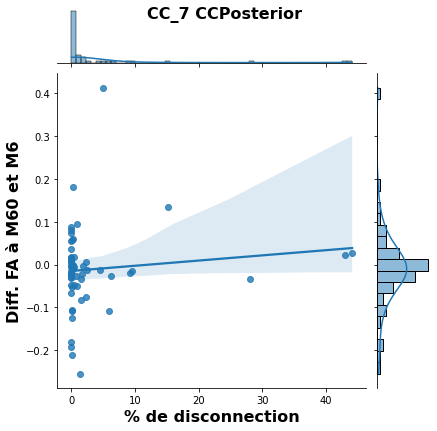

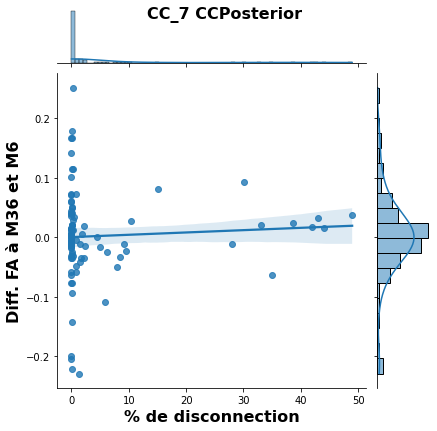

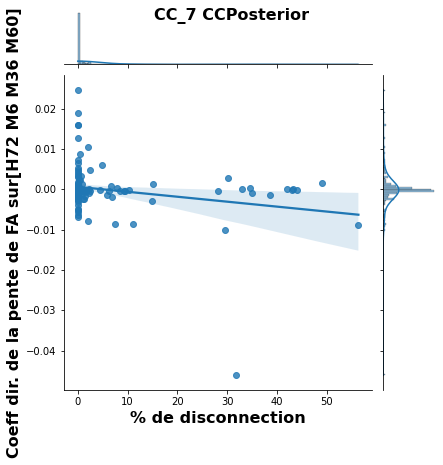

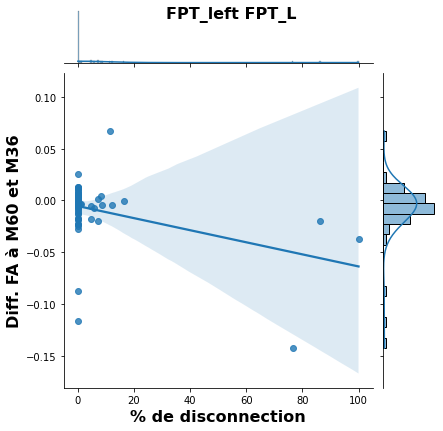

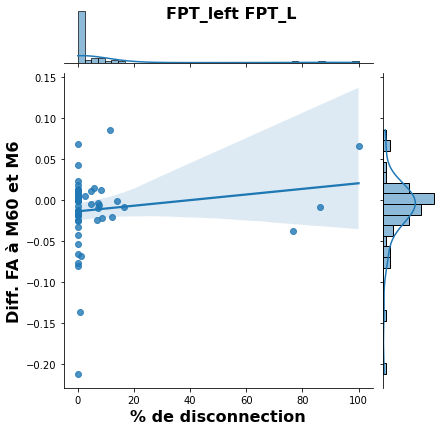

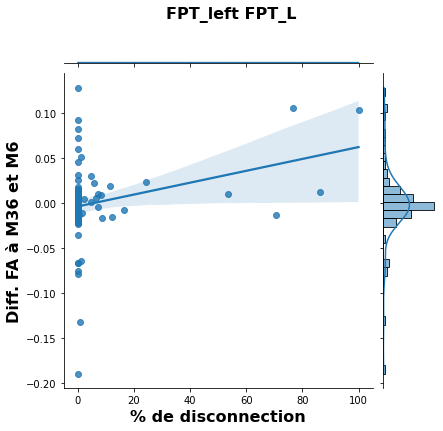

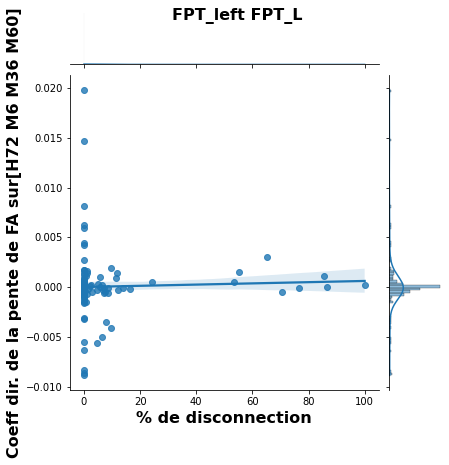

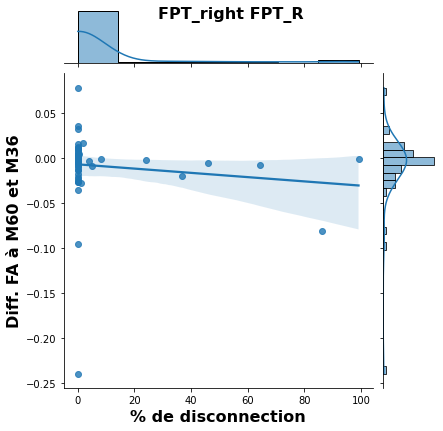

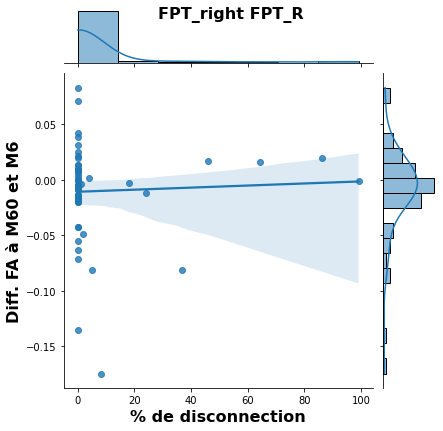

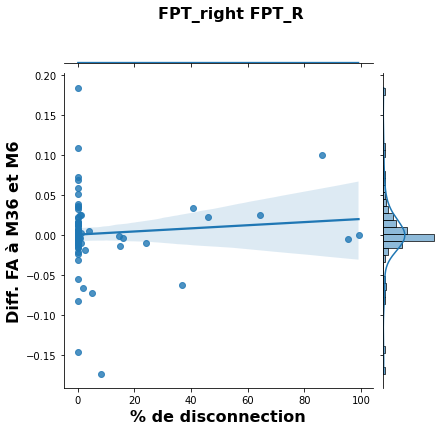

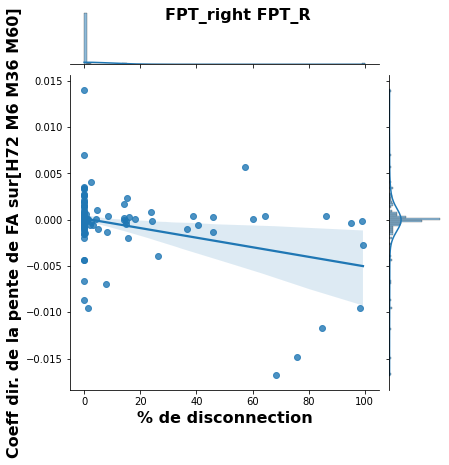

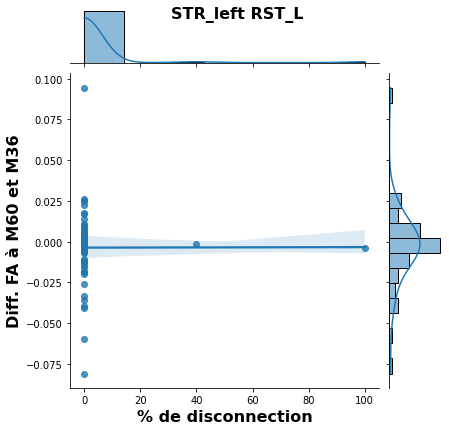

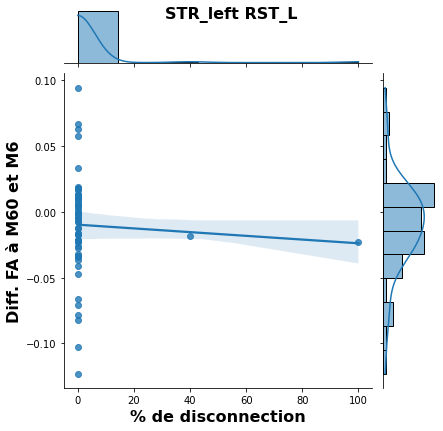

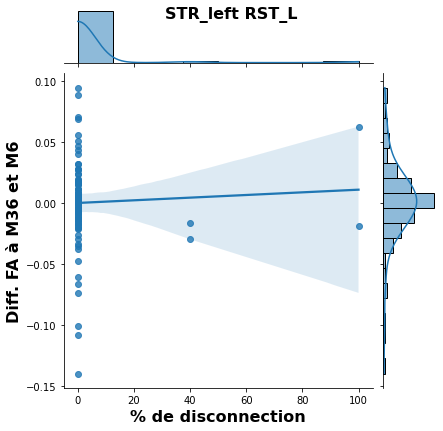

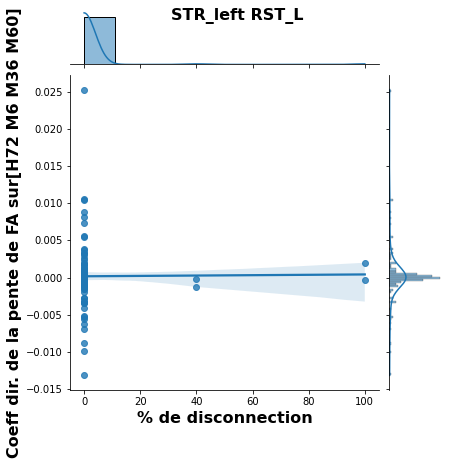

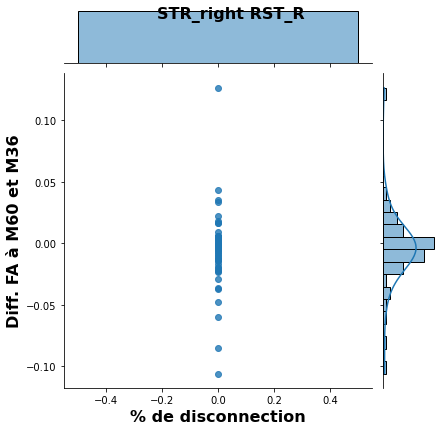

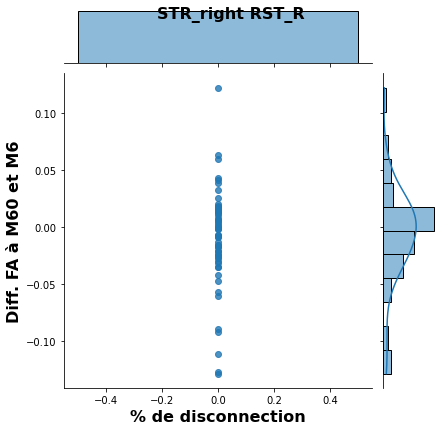

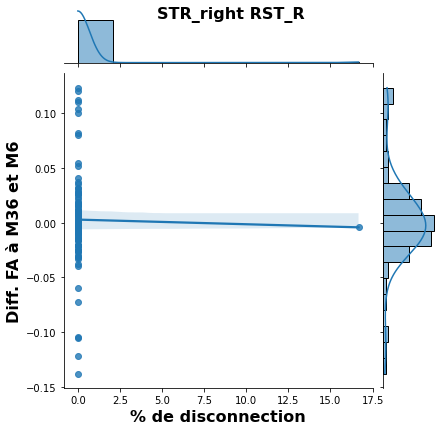

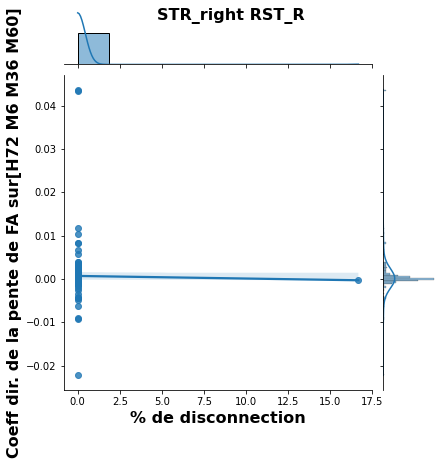

In [24]:
with open(os.path.join(TS_PATH,'DisconnectionVsFA_2.csv'),'w') as f:
    df_RL = pd.read_excel(TS_PATH+"/Disconnectome_renaud.xlsx",index_col=0,engine='openpyxl')
    for MET in ["_trk","_bundleseg"]:
        for cle,valeur in myDict.items():
            #Les fichiers csv sont obtenus avec la fonction GetMeanFAfromTrack dans runbash
            df_TS = pd.read_csv(TS_PATH+"/"+cle+MET+".csv",index_col='SUBJ')
            #df_new=df_TS.replace(0,'Nan')

            #METHODE RENAUD AVEC difference entre deux temps
            #Comparaison M60-M36
            df_TS_sel=df_TS[['M60','M36']].dropna()
            tmp=df_TS_sel[df_TS_sel.values[:,0]!=0]
            tmpD=tmp[tmp.values[:,1]!=0]
            data={'DisValues':np.array(df_RL.loc["sub-"+tmpD.index,valeur].values,dtype=float),'FA_Values':np.array(tmpD['M60'].values-tmpD['M36'].values,dtype=float)}
            g=sns.jointplot(x='DisValues',y='FA_Values',data=data,kind="reg")
            g.fig.suptitle(cle+" "+valeur,fontweight='bold',fontsize=16)
            g.ax_joint.set_ylabel('Diff. FA à M60 et M36',fontweight='bold',fontsize=16)
            g.ax_joint.set_xlabel('% de disconnection',fontweight='bold',fontsize=16)            
            g.savefig(os.path.join(TS_PATH,cle+'_M60_M36'+MET+".png"),transparent=False)
            slope, intercept, r, p, se = linregress(data['DisValues'],data['FA_Values'])
            print(cle,valeur,'M60','M36',MET,np.round(r,4),np.round(p,4),np.round(se,4),file=f,sep=',')
            
            #METHODE RENAUD AVEC difference entre deux temps
            #Comparaison M60-M6
            df_TS_sel=df_TS[['M60','M6']].dropna()
            tmp=df_TS_sel[df_TS_sel.values[:,0]!=0]
            tmpD=tmp[tmp.values[:,1]!=0]
            data={'DisValues':np.array(df_RL.loc["sub-"+tmpD.index,valeur].values,dtype=float),'FA_Values':np.array(tmpD['M60'].values-tmpD['M6'].values,dtype=float)}
            g=sns.jointplot(x='DisValues',y='FA_Values',data=data,kind="reg")
            g.fig.suptitle(cle+" "+valeur,fontweight='bold',fontsize=16)
            g.ax_joint.set_ylabel('Diff. FA à M60 et M6',fontweight='bold',fontsize=16)
            g.ax_joint.set_xlabel('% de disconnection',fontweight='bold',fontsize=16)
            g.savefig(os.path.join(TS_PATH,cle+'_M60_M6'+MET+".jpg"))
            slope, intercept, r, p, se = linregress(data['DisValues'],data['FA_Values'])
            print(cle,valeur,'M60','M6',MET,np.round(r,4),np.round(p,4),np.round(se,4),file=f,sep=',')

            #METHODE RENAUD AVEC difference entre deux temps
            #Comparaison M36-M6
            df_TS_sel=df_TS[['M36','M6']].dropna()
            tmp=df_TS_sel[df_TS_sel.values[:,0]!=0]
            tmpD=tmp[tmp.values[:,1]!=0]
            data={'DisValues':np.array(df_RL.loc["sub-"+tmpD.index,valeur].values,dtype=float),'FA_Values':np.array(tmpD['M36'].values-tmpD['M6'].values,dtype=float)}
            g=sns.jointplot(x='DisValues',y='FA_Values',data=data,kind="reg")
            g.fig.suptitle(cle+" "+valeur,fontweight='bold',fontsize=16)
            g.ax_joint.set_ylabel('Diff. FA à M36 et M6',fontweight='bold',fontsize=16)
            g.ax_joint.set_xlabel('% de disconnection',fontweight='bold',fontsize=16)
            g.savefig(os.path.join(TS_PATH,cle+'_M36_M6'+MET+".jpg"))
            slope, intercept, r, p, se = linregress(data['DisValues'],data['FA_Values'])
            print(cle,valeur,'M36','M6',MET,np.round(r,4),np.round(p,4),np.round(se,4),file=f,sep=',')
            
            #METHODE ROMAIN AVEC le calcul de la pente (forte pente neg. = degradation)
            time=np.array([0,6,36,60])
            slope_array=[]
            subj_list=list()
            for subj in df_RL.index.dropna():
                val=df_TS.loc[subj[4:],['72H','M6','M36','M60']].values
                pres=val>0
                if any(pres):
                    slope, intercept, r, p, se = linregress(time[pres],val[pres])
                    #print(subj,pres,test[pres],val[pres],np.round(slope,4))
                    slope_array.append(slope)
                    subj_list.append(subj)
            data={'DisValues':np.array(df_RL.loc[subj_list,valeur].values,dtype=float),'Slope_Values':np.array(slope_array,dtype=float)}
            g=sns.jointplot(x='DisValues',y='Slope_Values',data=data,kind="reg")
            g.fig.suptitle(cle+" "+valeur,fontweight='bold',fontsize=16)
            g.ax_joint.set_ylabel('Coeff dir. de la pente de FA sur [H72 M6 M36 M60]',fontweight='bold',fontsize=16)                  
            g.ax_joint.set_xlabel('% de disconnection',fontweight='bold',fontsize=16)
            g.savefig(os.path.join(TS_PATH,cle+'_reg'+MET+".jpg"))
            slope, intercept, r, p, se = linregress(data['DisValues'][~np.isnan(data['Slope_Values'])],data['Slope_Values'][~np.isnan(data['Slope_Values'])])                  
            print(cle,valeur,'regression','X',MET,np.round(r,4),np.round(p,4),np.round(se,4),file=f,sep=',')

In [ ]:
/NAS/tupac/protocoles/Strokdem/data/480221GR/lesion/lesion.nii.gz

/NAS/deathrow/renaud/dti_disconnection/tractography_atlas/All_Tracts/
/NAS/deathrow/renaud/dti_disconnection/bids_proc/antsREG_H72_M6/sub-36.../whole_brain*tck

/NAS/dumbo/protocoles/Strokdem_discon/data/M60/480221GR/bet_480221GR.nii.gz

/NAS/tupac/protocoles/Strokdem/Radiomique_SB_LoicDuron_2021/FreeSurfer_Output

In [6]:
for TMP in ["72H"] :
    listeFile=glob.glob('/NAS/tupac/protocoles/Strokdem/data/*/*'+TMP+'/*.bval')
    listeFileWox=[string for string in listeFile if not "x201" in string]
    listeFileWox=[file for file in listeFileWox if os.path.isfile(file) and os.path.isfile(file.replace('bval','nii.gz')) and os.path.isfile(file.replace('bval','bvec')) ]    
    listeFileWox=[ string.replace('bval','nii.gz') for string in listeFileWox ]    
    

In [9]:
[ file for file in listeFileWox if file.find('480221GR')>0 ]

['/NAS/tupac/protocoles/Strokdem/data/480221GR/480221GR_72H/20110303_090202WIPDTI15dirserie1SENSEs801a1008.nii.gz']

# Cohérence des fx atteint entre atlas et TracSeg

In [242]:
fileRL="/NAS/deathrow/renaud/dti_disconnection/bids_proc/cobalts/mmp_yeo7_Syn_soft/tract_discon_052022.csv"
fileTractSegRV="/NAS/tupac/protocoles/Strokdem/TractSeg/Disconnection_TractSeg.csv"

In [243]:
dfRL = pd.read_csv(fileRL,index_col=0)
dfRV = pd.read_csv(fileTractSegRV,index_col=0)

In [81]:
RL_set = set(dfRL['AF_L'].index)
RV_set = set(dfRV['AF_left'].index)
RL_set-RV_set

set()

Donc tous les sujets dans RL sont présents dans RV (par contre il y en à plus dans RV)

In [247]:
dfRLRV=dfRV.join(dfRL.iloc[:,199:264],lsuffix='RV',rsuffix='RL')
dfRLRV=dfRLRV.loc[RL_set,:]

On ne garde que les patients communs

In [248]:
myDict = {"AF_left":"AF_L",
"AF_right":"AF_R",
"CA":"AC",
"CC_1":"CCAnterior",
"CC_2":"CCMidAnterior",
"CC_3":"CCMidAnterior",
"CC_4":"CCCentral",
"CC_5":"CCMidPosterior",
"CC_6":"CCMidPosterior",
"CC_7":"CCPosterior",
"CST_left":"CST_L",
"CST_right":"CST_R",
"FPT_left":"FPT_L",
"FPT_right":"FPT_R",
"FX_left":"F_L",
"FX_right":"F_R",
"ICP_left":"ICP_L",
"ICP_right":"ICP_R",
"IFO_left":"IFOF_L",
"IFO_right":"IFOF_R",
"ILF_left":"ILF_L",
"ILF_right":"ILF_R",
"MCPRV":"MCPRL",
"MLF_left":"MdLF_L",
"MLF_right":"MdLF_R",
"OR_left":"OR_L",
"OR_right":"OR_R",
"UF_left":"UF_L",
"UF_right":"UF_R",
"SLF_III_left":"SLF_L",
"SLF_III_right":"SLF_R",
}

In [252]:
#Les pts sub-321230AL sub-321230AL ont des valeurs de disconnections importantes (>50) pour TractSeg et nulle (=0) dans l'atlas pour le fx arqué
dfRLRV[dfRLRV['CST_left']>50][['CST_left','CST_L']]

,CST_left,CST_L
SUBJ,,
sub-360821GV,65,76.14715
sub-511202MS,82,32.63449
sub-260409RD,100,24.32753
sub-380611JL,94,100.00000
sub-430602SD,83,68.39399
sub-560525GM,68,24.72310
sub-480414GL,77,48.57595


In [254]:
#Les pts sub-560525GM sub-680930WD sub-680917AG sub-710509KM ont des valeurs de disconnections nulles (=0) pour TractSeg et importante (>50) dans l'atlas pour le fx arqué
dfRLRV[dfRLRV['CST_L']<10][['CST_left','CST_L']]
#Ces patients n'ont pas de lesions défini dans /NAS/tupac/protocoles/Strokdem/data/680917AG/lesion

,CST_left,CST_L
SUBJ,,
sub-300403PP,0,0.0
sub-290729JL,0,0.0
sub-580620CG,0,0.0
sub-490226YB,0,0.0
sub-380126NB,0,0.0
...,...,...
sub-720501GL,0,0.0
sub-310109JP,0,0.0
sub-761229PN,0,0.0


In [265]:
dfRLRV[(dfRLRV['CST_L']<10) & (dfRLRV['CST_left']>10)][['CST_left','CST_L']]

,CST_left,CST_L
SUBJ,,
sub-391130GW,11,3.916139


In [277]:
dfRLRV[(dfRLRV['CST_left']>80) & (dfRLRV['CST_L']>80)][['CST_left','CST_L']]

,CST_left,CST_L
SUBJ,,
sub-380611JL,94,100.0


In [267]:
dfRLRV[(dfRLRV['CST_left']<10) & (dfRLRV['CST_L']>30)][['CST_left','CST_L']]

,CST_left,CST_L
SUBJ,,
sub-340303JV,0,99.32754
sub-500522FM,0,85.00791
sub-371116SD,0,52.41298
sub-470924PV,0,31.40823
sub-510807WC,0,100.00000
sub-421028RB,0,63.29114
sub-320319RV,0,48.73418
sub-321230AL,0,36.94620
sub-350112GC,0,30.10285


#Explication pour le patient sub-340303JV (la lesion prend tout le chemin du CST_left) : 
freeview /NAS/dumbo/protocoles/Strokdem_discon/data/72H/340303JV/WM_FODs.nii.gz /NAS/dumbo/protocoles/Strokdem_discon/data/72H/340303JV/endings_segmentations/CST_left_b.nii.gz /NAS/dumbo/protocoles/Strokdem_discon/data/72H/340303JV/endings_segmentations/CST_left_e.nii.gz /NAS/dumbo/protocoles/Strokdem_discon/data/72H/340303JV/bundle_segmentations/CST_left.nii.gz /NAS/dumbo/protocoles/Strokdem_discon/data/72H/340303JV/bundle_segmentations/AF_left.nii.gz /NAS/dumbo/protocoles/Strokdem_discon/data/72H/340303JV/endings_segmentations/AF_left_* /NAS/deathrow/renaud/dti_disconnection/bids_proc/infarct_gk/sub-340303JV/lesion_340303JV_72H_warped.nii.gz

freeview /NAS/dumbo/protocoles/Strokdem_discon/data/72H/500522FM/WM_FODs.nii.gz /NAS/dumbo/protocoles/Strokdem_discon/data/72H/500522FM/endings_segmentations/CST_left_b.nii.gz /NAS/dumbo/protocoles/Strokdem_discon/data/72H/500522FM/endings_segmentations/CST_left_e.nii.gz /NAS/dumbo/protocoles/Strokdem_discon/data/72H/500522FM/bundle_segmentations/CST_left.nii.gz /NAS/dumbo/protocoles/Strokdem_discon/data/72H/500522FM/bundle_segmentations/AF_left.nii.gz /NAS/dumbo/protocoles/Strokdem_discon/data/72H/500522FM/endings_segmentations/AF_left_* /NAS/deathrow/renaud/dti_disconnection/bids_proc/infarct_gk/sub-500522FM/lesion_500522FM_72H_warped.nii.gz 

CST_left CST_L TractSeg HCP1065 0.4989 0.0 0.0763


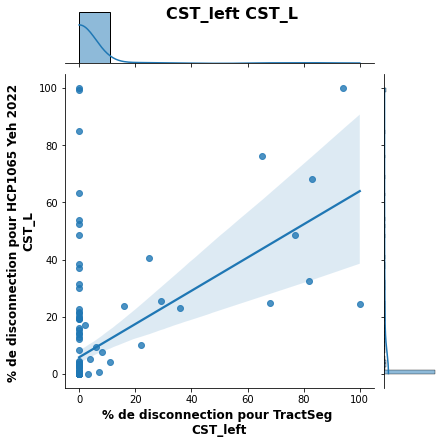

In [276]:
miniDict={"CST_left":"CST_L"}
for cle,valeur in miniDict.items():#myDict.items():
    g=sns.jointplot(x=cle,y=valeur,data=dfRLRV,kind="reg")   
    g.fig.suptitle(cle+" "+valeur,fontweight='bold',fontsize=16)
    g.ax_joint.set_xlabel('% de disconnection pour TractSeg \n' +cle,fontweight='bold',fontsize=12)                  
    g.ax_joint.set_ylabel('% de disconnection pour HCP1065 Yeh 2022 \n' + valeur ,fontweight='bold',fontsize=12)
    g.savefig(os.path.join(TS_PATH,"RVRL_"+cle+'_reg'+".jpg"))
    slope, intercept, r, p, se = linregress(dfRLRV.loc[:,cle],dfRLRV.loc[:,valeur])
    print(cle,valeur,'TractSeg','HCP1065',np.round(r,4),np.round(p,4),np.round(se,4))

# Déterminer si le % de disconnection prédit la différence d’épaisseur corticale.  

## Recupère une listes des faisceaux possible 

In [388]:
listeFile=glob.glob('/NAS/dumbo/protocoles/Strokdem_discon/data/72H/*/cTk_full.csv')    
myset=set()
for file in listeFile:
    if os.path.getsize(file) > 0:
        df = pd.read_csv(file,index_col='Bundle')
        if (df.shape[0]>0) :
            myset.update(set(df.index))

In [ ]:
    if (len(result_ind)>2):
        for THICK in ["CT0","CT5","CT10","CT15","CT20"]:            
            result_ind['TIME']=result_ind['TIME'].astype('float')
            model_formula = THICK+" ~  TIME * GROUP"
            model = smf.mixedlm(model_formula,data=result_ind.dropna(),groups=result_ind.dropna()['GROUP'])
            result_mlm = model.fit()
            if (result_mlm.pvalues[1:]<1).any():
                print(THICK)
                print(result_mlm.summary())  
                plt.figure(figsize=(12,6))
                #list_col=['CT_M0_'+THICK[2:],'CT_M6_'+THICK[2:],'CT_M36_'+THICK[2:],'CT_M60_'+THICK[2:]]
                #sns.lineplot(data=result_app[result_app['GROUP']=='IN'][list_col].T,palette="light:g",dashes=False)
                #sns.lineplot(data=result_app[result_app['GROUP']=='OUT'][list_col].T,palette="light:r",dashes=False)
                sns.violinplot(x="TIME", y=THICK,hue="GROUP",data=result_ind,inner="points",split=True,palette=['lightgreen','lightcoral'],width=0.8)
                #plt.legend(labels=['IN','OUT'],loc='upper right')
                plt.title(BUNDLE)
                #sns.regplot(x="TIME",y='CT0',data=result,scatter=False,color='red')

                sns.stripplot(data=result_ind,x="TIME",y=THICK,dodge=True,hue='GROUP',palette=['green','red'])
                plt.legend().remove()
                plt.legend(labels=['OUT','IN'],handles=[
                  plt.Line2D([0],[0],color='green',lw=4),
                  plt.Line2D([0],[0],color='red',lw=4),
                ],loc='upper right')
                plt.show()   
                FIG_FILE=os.path.join("/NAS","dumbo","protocoles","FAIRPARKII","screenshots","CT_OUT_IN",THICK+"_"+cle_TIME+"_"+BUNDLE+".jpg")
                plt.savefig(FIG_FILE,dpi=300)
                break

In [396]:
result_ind

,CT0,CT5,CT10,CT15,CT20,TIME,GROUP,SUBJ
0,2.199933,2.099799,2.093407,2.093430,2.093437,0,OUT,510702MFB
1,1.892222,1.870148,1.950231,2.036382,2.084429,0,IN,510702MFB
2,2.063488,1.973182,1.968811,1.968836,1.968840,36,OUT,510702MFB
3,1.824360,1.871562,1.914364,1.941523,1.962149,36,IN,510702MFB


In [397]:
dict_TIME={}
dict_TIME['72H']=0
dict_TIME['M6']=6
dict_TIME['M36']=36
dict_TIME['M60']=60
for BUNDLE in [bdx for bdx in myset if bdx.startswith("whole_brain_interLes") or bdx.startswith("FPT") or bdx.startswith("CC")]:#['whole_brain_interLes'] : #: #
    print(BUNDLE)
    result_ind = pd.DataFrame(columns=['CT0','CT5','CT10','CT15','CT20','TIME','GROUP','SUBJ'])
    for cle_TIME,val_TIME in dict_TIME.items() : #["72H","M6","M36","M60"]:
        listeFile=glob.glob('/NAS/dumbo/protocoles/Strokdem_discon/data/'+cle_TIME+'/*/cTk_full.csv')    
        for file in listeFile:
            if os.path.getsize(file) > 0:
                df = pd.read_csv(file,index_col='Bundle')
                if (df.shape[0]>0) :
                    if BUNDLE in df.index :
                        out_cols = df.filter(like='out')               
                        out_cols = out_cols.loc[BUNDLE].to_frame().transpose() #out_cols.loc["whole_brain_interLes"]                
                        out_cols.columns = out_cols.columns.str.replace('out','')
                        out_cols['TIME']=val_TIME
                        out_cols['GROUP']="OUT"
                        result_ind=pd.concat([result_ind,out_cols],ignore_index=True)

                        out_cols = df.filter(like='in')
                        out_cols = out_cols.loc[BUNDLE].to_frame().transpose()#out_cols.loc["whole_brain_interLes"]
                        out_cols.columns = out_cols.columns.str.replace('in','')
                        out_cols['TIME']=val_TIME
                        out_cols['GROUP']="IN"
                        result_ind=pd.concat([result_ind,out_cols],ignore_index=True)    
                        result_ind['SUBJ']=listeFile[0].split('/')[-2]
    print(result_ind.shape)


CCfiltered_interLes
(16, 8)
FPT_rightfiltered_interLes
(108, 8)
CC_3_interLes
(84, 8)
CC_2_interLes
(184, 8)
CC_4_interLes
(130, 8)
CC_5filtered_interLes
(152, 8)
CC_6_interLes
(404, 8)
CC_1_interLes
(12, 8)
CC_5_interLes
(178, 8)
FPT_right_interLes
(124, 8)
whole_brain_interLes
(738, 8)
CC_3filtered_interLes
(66, 8)
CC_7_interLes
(114, 8)
CC_interLes
(552, 8)
CC_7filtered_interLes
(92, 8)
FPT_left_interLes
(156, 8)
CC_2filtered_interLes
(138, 8)
CC_4filtered_interLes
(78, 8)
CC_6filtered_interLes
(286, 8)
CC_1filtered_interLes
(12, 8)
FPT_leftfiltered_interLes
(116, 8)


In [218]:
result_app = pd.DataFrame(columns=['CT_M0_0','CT_M0_5','CT_M0_10','CT_M0_15','CT_M0_20','CT_M6_0','CT_M6_5','CT_M6_10','CT_M6_15','CT_M6_20','CT_M36_0','CT_M36_5','CT_M36_10','CT_M36_15','CT_M36_20','CT_M60_0','CT_M60_5','CT_M60_10','CT_M60_15','CT_M60_20','GROUP'])
dict_TIME={}
dict_TIME['M6']=6
dict_TIME['M36']=36
dict_TIME['M60']=60

listeFile=glob.glob('/NAS/dumbo/protocoles/Strokdem_discon/data/72H/*/cTk_full.csv')    
for file in listeFile:
    if os.path.getsize(file) > 0:
        df = pd.read_csv(file,index_col='Bundle')
        if (df.shape[0]>0) :
            result_tmp = pd.DataFrame(columns=['CT_M0_0','CT_M0_5','CT_M0_10','CT_M0_15','CT_M0_20','CT_M6_0','CT_M6_5','CT_M6_10','CT_M6_15','CT_M6_20','CT_M36_0','CT_M36_5','CT_M36_10','CT_M36_15','CT_M36_20','CT_M60_0','CT_M60_5','CT_M60_10','CT_M60_15','CT_M60_20','GROUP'])
            out_cols = df.filter(like='out')
            out_cols = out_cols.loc["whole_brain_interLes"].to_frame().transpose() 
            out_cols.columns = out_cols.columns.str.replace('out','_M0_')
            #listPat = [string for val in out_cols.index if not "_ii" in string]
            for cle_TIME,valeur_TIME in dict_TIME.items() : 
                file_tmp=file.replace("72H",cle_TIME)
                if os.path.exists(file_tmp) and os.path.getsize(file_tmp) > 0:
                    df = pd.read_csv(file,index_col='Bundle')
                    out_cols_tmp = df.filter(like='out')               
                    out_cols_tmp = out_cols_tmp.loc["whole_brain_interLes"].to_frame().transpose() 
                    out_cols_tmp.columns = out_cols_tmp.columns.str.replace('out',"_"+cle_TIME+"_")                
                    out_cols=pd.concat([out_cols,out_cols_tmp],axis=1)                
            out_cols['GROUP']="OUT"
            result_app=pd.concat([result,out_cols],ignore_index=True)
            
            result_tmp = pd.DataFrame(columns=['CT_M0_0','CT_M0_5','CT_M0_10','CT_M0_15','CT_M0_20','CT_M6_0','CT_M6_5','CT_M6_10','CT_M6_15','CT_M6_20','CT_M36_0','CT_M36_5','CT_M36_10','CT_M36_15','CT_M36_20','CT_M60_0','CT_M60_5','CT_M60_10','CT_M60_15','CT_M60_20','GROUP'])
            out_cols = df.filter(like='in')
            out_cols = out_cols.loc["whole_brain_interLes"].to_frame().transpose() 
            out_cols.columns = out_cols.columns.str.replace('in','_M0_')
            #listPat = [string for val in out_cols.index if not "_ii" in string]
            for cle_TIME,valeur_TIME in dict_TIME.items() : 
                file_tmp=file.replace("72H",cle_TIME)
                if os.path.exists(file_tmp) and os.path.getsize(file_tmp) > 0:
                    df = pd.read_csv(file,index_col='Bundle')
                    out_cols_tmp = df.filter(like='in')               
                    out_cols_tmp = out_cols_tmp.loc["whole_brain_interLes"].to_frame().transpose() 
                    out_cols_tmp.columns = out_cols_tmp.columns.str.replace('in',"_"+cle_TIME+"_")                
                    out_cols=pd.concat([out_cols,out_cols_tmp],axis=1)                
            out_cols['GROUP']="IN"
            result_app=pd.concat([result,out_cols],ignore_index=True)

CT20


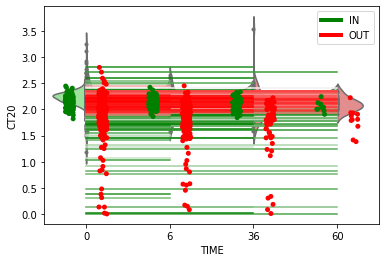

In [287]:
for THICK in ["CT20"]: #["CT0","CT5","CT10","CT15","CT20"]:
    print(THICK)
    list_col=['CT_M0_'+THICK[2:],'CT_M6_'+THICK[2:],'CT_M36_'+THICK[2:],'CT_M60_'+THICK[2:]]
    sns.lineplot(data=result_app[result_app['GROUP']=='IN'][list_col].T,palette="light:g",dashes=False)
    sns.lineplot(data=result_app[result_app['GROUP']=='OUT'][list_col].T,palette="light:r",dashes=False)
    sns.violinplot(x="TIME", y="CT0",hue="GROUP",data=result_ind,inner="points",split=True,palette=['lightgreen','lightcoral'],width=0.8)
    plt.legend(labels=['IN','OUT'],loc='upper right')
    #sns.regplot(x="TIME",y='CT0',data=result,scatter=False,color='red')

    sns.stripplot(data=result_ind,x="TIME",y=THICK,dodge=True,hue='GROUP',palette=['green','red'])
    #plt.legend().remove()
    plt.legend(labels=['IN','OUT'],handles=[
      plt.Line2D([0],[0],color='green',lw=4),
      plt.Line2D([0],[0],color='red',lw=4),
    ],loc='upper right')
    plt.show()

In [265]:
#sns.regplot(x="TIME",y='CT5',data=result_ind[result_ind['GROUP']=='IN'].dropna(),scatter=True,color='red')
from sklearn import linear_model
regr=linear_model.LinearRegression()
regr.fit(result_ind[result_ind['GROUP']=='IN'].dropna()["TIME"].values,result_ind[result_ind['GROUP']=='IN'].dropna()["CT0"].values)
plt.plot(result_ind[result_ind['GROUP']=='IN'].dropna()["TIME"].values,result_ind[result_ind['GROUP']=='IN'].dropna()["CT0"].values,'.')
plt.plot(result_ind[result_ind['GROUP']=='OUT'].dropna()["TIME"].values,result_ind[result_ind['GROUP']=='OUT'].dropna()["CT0"].values,'o')
print(regr.coef_)

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  6.  6.  6.  6.  6.  6.  6.  6.
  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.
  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.
  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.
  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.
  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.
  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.
  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6. 36. 36.
 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36.
 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36.
 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36. 36.
 36. 36. 36. 36. 36. 36. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60. 60.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [258]:
result_ind[result_ind['GROUP']=='IN'].dropna()[['CT5','TIME']].values

array([[1.89243343108942, 0],
       [1.4520112488569799, 0],
       [1.9524481843343002, 0],
       [1.6857358732955101, 0],
       [2.0203003481385298, 0],
       [1.9507771670333303, 0],
       [1.45548441312862, 0],
       [1.82384888783001, 0],
       [2.18032441103872, 0],
       [1.63278229923143, 0],
       [1.8583201696202298, 0],
       [1.88468575115142, 0],
       [1.93897033835058, 0],
       [1.9621582223973502, 0],
       [1.7441983978086697, 0],
       [1.7749026881194698, 0],
       [2.3977254349334, 0],
       [1.4077723037018302, 0],
       [1.50039052410285, 0],
       [1.16238694309193, 0],
       [1.70705551315029, 0],
       [1.7772699512932, 0],
       [1.7830551343836298, 0],
       [2.09026930632572, 0],
       [1.71136275352729, 0],
       [1.2895255805248602, 0],
       [1.93675892653042, 0],
       [2.19693099166134, 0],
       [1.92362080713179, 0],
       [1.5494215973047798, 0],
       [2.27795970114464, 0],
       [2.23760547261394, 0],
       [2.286489

In [157]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

model_formula = "CT20 ~  TIME * GROUP"
#model_formula = "value ~  timepoint * Group + (1 | SUBJ)"
model = smf.mixedlm(model_formula,data=result.dropna(),groups=result.dropna()['GROUP'])
result_mlm = model.fit()
print(result_mlm.summary())

                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      CT20     
No. Observations:      728          Method:                  REML     
No. Groups:            2            Scale:                   0.1042   
Min. group size:       359          Log-Likelihood:          -224.1256
Max. group size:       369          Converged:               Yes      
Mean group size:       364.0                                          
----------------------------------------------------------------------
                        Coef.    Std.Err.     z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                1.841        0.324  5.684 0.000  1.206  2.476
TIME[T.6]               -0.092        0.038 -2.401 0.016 -0.167 -0.017
TIME[T.36]              -0.101        0.049 -2.080 0.038 -0.196 -0.006
TIME[T.60]              -0.045        0.101 -0.445 0.656 -0.242  0.153
GROUP[T.OUT]           

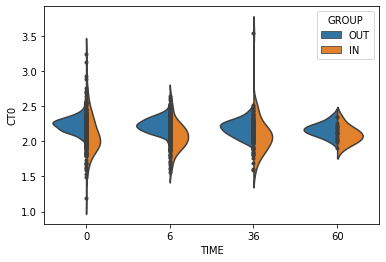

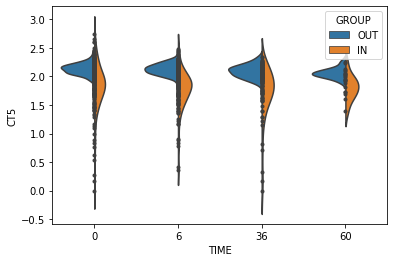

In [156]:
sns.violinplot(x="TIME", y="CT0",hue="GROUP",inner="points", data=result, split=True)
#sns.regplot(x="TIME",y='CT0',data=result,scatter=False,color='red')
plt.show()
sns.violinplot(x="TIME", y="CT5",hue="GROUP", inner="points",data=result, split=True)
plt.show()

## Epaissieur cortical & Disconnections

In [23]:
from nibabel.freesurfer.mghformat import load,save,MGHImage
import nibabel as nib

Permet de faire la somme des disconnections dans le repere fsaverage (avant d'extraire le cluster)

In [27]:
for TIME in ["M6"]:#["72H","M6","M36","M60"]:
    for LAT in ["lh","rh"]:
        for SMT in ["00","5","10","15","20"]:      
            ndarray_1d=np.zeros(163842)
            for FILE in glob.glob(os.path.join(TS_PATH,'CTsmoothed',"*"+TIME+'_'+LAT+".disconnection."+SMT+".mgh")) :
                data=load(FILE)
                data_data=data.get_fdata()
                ndarray_1d=ndarray_1d+data_data[:,0,0]                
            RES_FILE=os.path.join(TS_PATH,'CTsmoothed',TIME+'_'+LAT+".disconnection."+SMT+".sum.mgh")
            print(RES_FILE)
            #nib.freesurfer.io.write_morph_data(RES_FILE,ndarray_1d)
            #data_data[:,0,0]=ndarray_1d
            #data.set_filename(RES_FILE)
            print(FILE)
            sav=MGHImage(ndarray_1d,data.affine, header=data.header)
            sav.set_filename(RES_FILE)
            save(sav,RES_FILE)

/NAS/tupac/protocoles/Strokdem/TractSeg/CTsmoothed/M6_lh.disconnection.00.sum.mgh
/NAS/tupac/protocoles/Strokdem/TractSeg/CTsmoothed/400617LW_M6_lh.disconnection.00.mgh
/NAS/tupac/protocoles/Strokdem/TractSeg/CTsmoothed/M6_lh.disconnection.5.sum.mgh
/NAS/tupac/protocoles/Strokdem/TractSeg/CTsmoothed/761229PN_M6_lh.disconnection.5.mgh
/NAS/tupac/protocoles/Strokdem/TractSeg/CTsmoothed/M6_lh.disconnection.10.sum.mgh
/NAS/tupac/protocoles/Strokdem/TractSeg/CTsmoothed/460321JD_M6_lh.disconnection.10.mgh
/NAS/tupac/protocoles/Strokdem/TractSeg/CTsmoothed/M6_lh.disconnection.15.sum.mgh
/NAS/tupac/protocoles/Strokdem/TractSeg/CTsmoothed/610612HV_M6_lh.disconnection.15.mgh
/NAS/tupac/protocoles/Strokdem/TractSeg/CTsmoothed/M6_lh.disconnection.20.sum.mgh
/NAS/tupac/protocoles/Strokdem/TractSeg/CTsmoothed/391130GW_M6_lh.disconnection.20.mgh
/NAS/tupac/protocoles/Strokdem/TractSeg/CTsmoothed/M6_rh.disconnection.00.sum.mgh
/NAS/tupac/protocoles/Strokdem/TractSeg/CTsmoothed/470327JPE_M6_rh.disconne

In [220]:
import nibabel.freesurfer as nifs
data=nifs.io.read_morph_data('/NAS/deathrow/renaud/dti_disconnection/bids_proc/freesurfer/sub-510702MFB/sub-510702MFB-ses-3/surf/lh.white')
len(data)
#data_data=data.get_fdata()

2067679

In [230]:
import nibabel.freesurfer as nifs
data=nifs.io.read_geometry('/NAS/tupac/protocoles/Strokdem/FS5.1_T2mask/571216AT_M36/surf/lh.white')
len(data[0])

129972

In [231]:
import nibabel.freesurfer as nifs
data=nifs.io.read_geometry('/NAS/tupac/protocoles/Strokdem/FS5.1_T2mask/571216AT_M36/surf/rh.white')
len(data[0])

134621

In [30]:
my_res['group']=my_res['rh_M6_disconnection_cluster_1']=='NoDisconnection'

In [40]:
my_res[my_res['rh_M6_disconnection_cluster_1']==0]['group2']=='NoDisconnection'
#my_res[my_res['rh_M6_disconnection_cluster_1']>0]['group']==0

KeyError: 'group2'

0.020595992667243063 0.9836185882468542


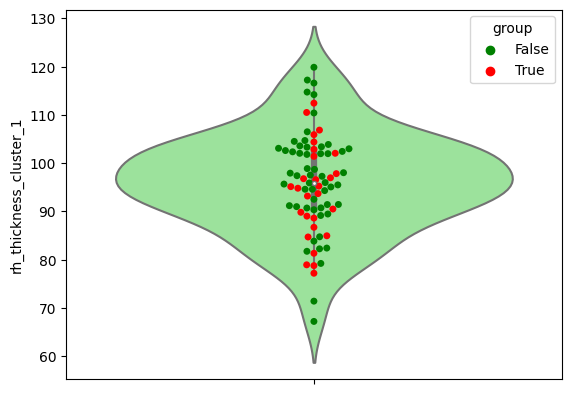

In [48]:
#sns.violinplot(data=tmp2,x="timepoint",y="Cerebellum total volume %",inner="points",split=True,hue='Group',palette=['lightgreen','lightcoral'])
#plt.legend(labels=['early PD (GP1)','AMS (GP4)'],loc='upper right')
import scipy.stats as stats

sns.swarmplot(data=my_res,y="rh_thickness_cluster_1",hue='group',palette=['green','red'])
sns.violinplot(data=my_res,y='rh_thickness_cluster_1',split=True,hue='group',palette=['lightgreen','lightcoral'])

t2, p2 = stats.ttest_ind(my_res[my_res['rh_M6_disconnection_cluster_1']==0]['rh_M6_thickness_cluster_1'],my_res[my_res['rh_M6_disconnection_cluster_1']>0]['rh_M6_thickness_cluster_1'])
print(t2, p2)

<AxesSubplot:ylabel='lh_thickness_cluster_1'>

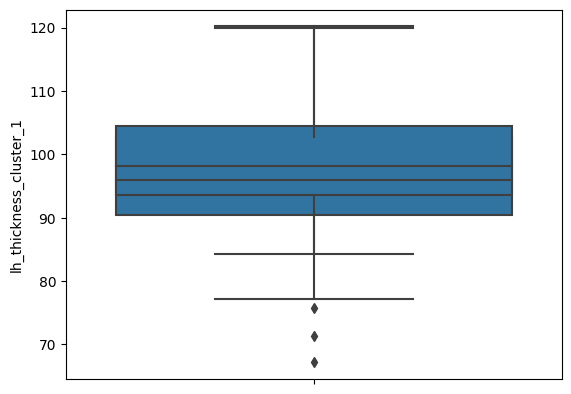

In [50]:
sns.boxplot(data=my_res,y='rh_thickness_cluster_1')
sns.boxplot(data=my_res,y='lh_thickness_cluster_1')

In [148]:
my_res.sort_values(by='lh_M6_DIS_cluster_1',ascending=False)[(['lh_M6_DIS_cluster_1','SUBJ'])]

,lh_M6_DIS_cluster_1,SUBJ
28,1.174195e+03,530512AS
32,1.148265e+03,461113JM
39,1.108020e+03,350605MM
38,1.085999e+03,310317GD
8,9.772425e+02,350112GC
43,9.534056e+02,500522FM
51,8.543917e+02,531122JC
18,8.164170e+02,521029PB
13,8.002021e+02,571216AT
27,7.606769e+02,380614FS
